# Data Scientist Professional Practical Exam

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

## Install and Import Modules

In [1]:
# Install modules not preinstalled in DC Workspaces
# !pip install dataprep
# !pip install forex_python
# !pip install ftfy
# !pip install missingpy

In [2]:
# Import modules
import pandas as pd
import numpy as np
import statsmodels as sm
import datetime as dt
import chardet as ch 
import missingno as msno
import random as rnd

from geopy import geocoders
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
from scipy import stats

from forex_python.converter import CurrencyRates
from ftfy import fix_and_explain, fix_text
from dataprep import clean

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OrdinalEncoder
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use('ggplot')
sns.set_context("notebook")
rnd.seed(42)
np.random.RandomState(42)


RandomState(MT19937) at 0x7F9BCB17CC40

# Load Data

In [3]:
with open('data/boat_data.csv', 'rb') as file:             # check CSV file encoding to reduce reding errors and data cleanup
    print(ch.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
df = pd.read_csv('data/boat_data.csv', encoding = "utf-8")     # load data into dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


In [5]:
df.describe()

Year Built       Length        Width  Number of views last 7 days
count  9888.000000  9879.000000  9832.000000                  9888.000000
mean   1893.192860    11.570017     3.520124                   149.160801
std     460.201582     6.002820     1.220534                   151.819752
min       0.000000     1.040000     0.010000                    13.000000
25%    1996.000000     7.470000     2.540000                    70.000000
50%    2007.000000    10.280000     3.330000                   108.000000
75%    2017.000000    13.930000     4.250000                   172.000000
max    2021.000000   100.000000    25.160000                  3263.000000

In [6]:
df.head(10)

Price            Boat Type          Manufacturer                 Type  \
0   CHF 3337          Motor Yacht  Rigiflex power boats  new boat from stock   
1   EUR 3490  Center console boat     Terhi power boats  new boat from stock   
2   CHF 3770           Sport Boat    Marine power boats  new boat from stock   
3  DKK 25900           Sport Boat    Pioner power boats  new boat from stock   
4   EUR 3399         Fishing Boat    Linder power boats  new boat from stock   
5   CHF 3650           Sport Boat    Linder power boats  new boat from stock   
6   CHF 3600            Catamaran                   NaN   Used boat,Unleaded   
7  DKK 24800           Sport Boat                   NaN            Used boat   
8   EUR 3333         Fishing Boat  Crescent power boats  new boat from stock   
9   EUR 3300         Pontoon Boat     Whaly power boats  new boat from stock   

   Year Built  Length  Width       Material  \
0        2017    4.00   1.90            NaN   
1        2020    4.00   1.50  Thermoplastic   
2           0    3.69   1.42      Aluminium   
3        2020    3.00   1.00            NaN   
4        2019    3.55   1.46      Aluminium   
5           0    4.03   1.56      Aluminium   
6        1999    6.20   2.38      Aluminium   
7           0    3.00    NaN            NaN   
8        2019    3.64   1.37            NaN   
9        2018    4.35   1.73            NaN   

                                        Location  Number of views last 7 days  
0         Switzerland Â» Lake Geneva Â» VÃ©senaz                          226  
1                       Germany Â» BÃ¶nningstedt                           75  
2     Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH                          124  
3                           Denmark Â» Svendborg                           64  
4                  Germany Â» Bayern Â» MÃ¼nchen                           58  
5        Switzerland Â» Lake Constance Â» Uttwil                          132  
6      Switzerland Â» Neuenburgersee Â» Yvonand                           474  
7                           Denmark Â» Svendborg                          134  
8  Germany Â» Bayern Â» Boote+service Oberbayern                           45  
9                          Italy Â» Dormelletto                           180

In [7]:
df.nunique()

Price                          3182
Boat Type                       126
Manufacturer                    910
Type                             24
Year Built                      122
Length                         1612
Width                           575
Material                         11
Location                       2995
Number of views last 7 days     674
dtype: int64

# Data Clean Up

To Dos:
* 	\[Price\]:  
	*  Parse Price into 'Currency' + 'Amount' columns 		✔
	*  Convert to Euros or USD  							✔
* 	\[Boat Type\]:
	* 	Search & Group Similar Categories
* 	\[Manufacturer\]:
	*	Remove "power boats"  									✔
	* 	Clean up characters 									✔
	* 	Fuzzy match manufacturers to reduce counts
* 	\[Type\]:
	* 	Parse Column into 'Condition' + 'Fuel Type' columns		✔
* 	\[Material\]:
	* 	- No Cleaning Needed -
* 	\[Location\]:
	* 	Parse Country, Region & City	
	* 	Correct Mispelled Words / Characters

## Data Clean Up: All Columns

## Data Clean Up:  'Price' Column

In [8]:
df[['Currency', 'Amount']] = df.Price.str.split(" ", expand=True )         # Split 'Price' into 'Currency' & 'Amount' 
print(df.Amount.isnull().values.any())                                     # Check there are non nulls in 'Amount'
print(df.Currency.isnull().values.any())                                   # Check there are non nulls in 'Currency'
print(df.Currency.unique())

False
False
['CHF' 'EUR' 'DKK' 'Â£']


In [9]:
df['Currency'] = df['Currency'].str.replace('Â£', 'GBP')                   # Clean up British Pound currency chars
print(df.Currency.unique())

['CHF' 'EUR' 'DKK' 'GBP']


In [10]:
df.Amount.str.isdigit().all()                       # Check that 'Amount' only contains numeric chars (no '.' or ',')

True

In [11]:
df['Amount'] = df['Amount'].astype('float64')         # Convert 'Amount' to numeric

In [12]:
# The following approach is too slow, as it has to perform 9k get requests

# curr = CurrencyRates()
# df['Amount (USD)'] = df.apply( lambda x: curr.convert( x.Currency, 'USD', x.Amount), axis = 1)

In [13]:
curr = CurrencyRates()
currencies = df.Currency.unique()
conversion_date = dt.datetime(2023, 1, 3)

rates = [curr.convert(i, 'USD', 1, conversion_date) for i in currencies]
rates_to_USD = dict(zip(currencies, rates))

print(rates_to_USD)

{'CHF': 1.0674157303370786, 'EUR': 1.0545, 'DKK': 0.1417910447761194, 'GBP': 1.1976421951662728}


In [14]:
df['Price (USD)'] = round(df['Amount'] * df['Currency'].map(rates_to_USD), 2)

## Data Clean Up : 'Boat Type' Column

In [15]:
#t = df['Boat Type'].unique()
#sorted(t)

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Boat Type').size())

Boat Type
Bowrider                                        301
Bowrider,Cabin Boat,Deck Boat                     1
Bowrider,Center console boat,Sport Boat           1
Bowrider,Classic                                  1
Bowrider,Deck Boat,Water ski                      1
Bowrider,Motor Yacht,Sport Boat                   1
Bowrider,Motor Yacht,Wakeboard/Wakesurf           1
Bowrider,Sport Boat,Wakeboard/Wakesurf            2
Bowrider,Wakeboard/Wakesurf                       1
Cabin Boat                                      585
Cabin Boat,Classic                                9
Cabin Boat,Classic,Flybridge                      1
Cabin Boat,Classic,Motor Yacht                    3
Cabin Boat,Classic,Passenger boat                 1
Cabin Boat,Classic,Trawler                        1
Cabin Boat,Fishing Boat                           2
Cabin Boat,Fishing Boat,House Boat                1
Cabin Boat,Fishing Boat,Pilothouse                1
Cabin Boat,Fishing Boat,Sport Boat                1
Ca

In [17]:
df['Boat Type'].str.contains(',').sum()*100/df.shape[0]

2.9935275080906147

In [18]:
df['Boat Type - Main'] = df['Boat Type'].map(lambda x: x.split(',')[0])
df['Boat Type - Subtype'] = df['Boat Type'].map(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else '')
df['Boat Type - Subtype'].unique()

array(['', 'Working Boat', 'Classic', 'Pilothouse', 'Trawler',
       'Sport Boat', 'Runabout', 'Motor Yacht', 'Launch', 'Pontoon Boat',
       'Motorsailer', 'Wakeboard/Wakesurf', 'Water ski', 'Flybridge',
       'Hardtop', 'House Boat', 'Mega Yacht', 'Deck Boat', 'Cabin Boat',
       'Fishing Boat', 'Center console boat', 'Passenger boat'],
      dtype=object)

In [19]:
print(df.groupby('Boat Type - Main').size())

Boat Type - Main
Bowrider                310
Cabin Boat              654
Catamaran                26
Center console boat     377
Classic                 203
Deck Boat               285
Fishing Boat            179
Flybridge              1203
Hardtop                 513
House Boat              148
Ketch                     1
Launch                   55
Mega Yacht              108
Motor Yacht            2736
Motorsailer               3
Offshore Boat            57
Passenger boat           36
Pilothouse              614
Pontoon Boat             91
RIB                       1
Runabout                 78
Sport Boat             1417
Trawler                 679
Wakeboard/Wakesurf       60
Water ski                10
Working Boat             44
dtype: int64


In [20]:
print(df.groupby('Boat Type - Subtype').size())

Boat Type - Subtype
                       9592
Cabin Boat                1
Center console boat       1
Classic                  18
Deck Boat                 6
Fishing Boat              8
Flybridge                14
Hardtop                   8
House Boat                8
Launch                    5
Mega Yacht                2
Motor Yacht              63
Motorsailer               1
Passenger boat            1
Pilothouse                6
Pontoon Boat              5
Runabout                 64
Sport Boat               55
Trawler                  12
Wakeboard/Wakesurf        9
Water ski                 5
Working Boat              4
dtype: int64


## Data Clean Up: 'Manufacturer' Column

In [21]:
#t = df['Manufacturer'].fillna('None').unique()
#sorted(t)

In [22]:
df['Manufacturer'] = df['Manufacturer'].fillna('None')
df['Manufacturer'] = df['Manufacturer'].str.replace(' power boats', '')
df[df.Manufacturer.str.contains(r'[^0-9a-zA-Z -.]')].Manufacturer.unique()      # List misspelled Manufacturers

array(['BÃ©nÃ©teau', 'MÃ¤ndli', 'SkilsÃ¶', 'FÃ¼llemann', 'ManÃ²',
       'KaasbÃ¸ll', 'TigÃ©', 'Ã\x96chsner', 'LÃ¼rssen Yachts', 'HervÃ©',
       'Holland StahlverdrÃ¤nger', 'LÃ¼tje'], dtype=object)

In [23]:
df['Manufacturer'] = [fix_text(i) for i in df['Manufacturer']]
t = df['Manufacturer'].unique()
sorted(t)

['2 emme marine',
 '3B Craft',
 'A. Mostes',
 'AB Yachts',
 'ACM Dufour',
 'AGA-Marine',
 'AICON Yachts',
 'AL Custom',
 'AM Yacht',
 'AMS Marine Yachten',
 'AMT',
 'ARS Mare',
 'AS Marine',
 'ATOMIX',
 'AW',
 'AW Yachts',
 'AXOPAR',
 'AYROS',
 'Abacus',
 'Abati Yachts',
 'Abeking & Rasmussen',
 'Absolute',
 'Acquaviva (IT)',
 'Acroplast',
 'Adagio Yachts',
 'Adec',
 'Adex Nautica',
 'Adler',
 'Admiral',
 'Adventure',
 'Aegean Yachts',
 'Agder',
 'Aicon',
 'Airon Marine',
 'Akerboom',
 'Ala Blu',
 'Alalunga',
 'Albatro',
 'Albemarle',
 'Albin',
 'Alen Yacht',
 'Alfamarine',
 'Alfastreet Marine',
 'Allegra',
 'Allround',
 'Alpa',
 'Altair',
 'Altena',
 'AluForce',
 'AluVenture',
 'Aluminiumjon',
 'Amberg',
 'Amel',
 'Amer',
 'Amerglass',
 'American Marine',
 'Ancora',
 'Antaris',
 'Anytec',
 'Anytec Boats',
 'Apreamare',
 'Aquabat',
 'Aquador',
 'Aqualum',
 'Aquanaut',
 'Aquarius',
 'Aquastar',
 'Aquaviva',
 'Arcoa',
 'Argo',
 'Arkos',
 'Armee Suisse',
 'Arp-Werft ',
 'Arvor',
 'Astinor

In [24]:
mfct_count = pd.DataFrame({ 'count' : df.groupby('Manufacturer').size()}).reset_index() 
mfct_singles = mfct_count[mfct_count['count'] == 1] 
mfct_singles.sum()

Manufacturer    2 emme marineAB YachtsAGA-MarineAL CustomAMS M...
count                                                         397
dtype: object

In [25]:
df.loc[df['Manufacturer'].isin(mfct_singles['Manufacturer']), 'Manufacturer'] = 'Other'  # Group Boat Mfct with 1 boat to 'Other' Category

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Manufacturer').size().sort_values(ascending = False))

Manufacturer
None                              1338
Bénéteau                           631
Jeanneau                           537
Other                              397
Sunseeker                          383
Princess                           241
Sea Ray                            239
Cranchi                            219
Azimut                             215
Bavaria                            185
Fairline                           172
Quicksilver (Brunswick Marine)     167
Sessa                              148
Bayliner                           142
Sealine                            120
Quicksilver                        118
Prestige Yachts                    108
Galeon                              94
Regal                               90
Riva                                77
Linssen                             70
Windy                               64
Ferretti                            63
Parker                              62
Boesch                              55
Pershing    

## Data Clean Up: 'Type' Column

In [27]:
t = df['Type'].fillna('None').unique()
#sorted(t)
print(df.groupby('Type').size().sort_values(ascending = False))

Type
Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat                       1462
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       150
Display Model,Unleaded            75
new boat on order,Diesel          61
new boat on order                 61
Diesel                            57
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
Display Model                     18
new boat from stock,Electric      18
Used boat,Gas                     10
Display Model,Electric             6
new boat from stock,Gas            2
Used boat,Propane                  1
Electric                           1
new boat from stock,Hybrid         1
Display Model,Gas                  1
Used boat,Hybrid                   1
dtype: int64


In [28]:
[*set(np.char.partition(df['Type'].fillna('None').unique().tolist(), ',').flatten().tolist())]

['',
 'Display Model',
 'Diesel',
 'new boat from stock',
 'None',
 'Propane',
 'Hybrid',
 'Electric',
 'Used boat',
 'Gas',
 'new boat on order',
 ',',
 'Unleaded']

In [29]:
condition_lst = ['Used boat', 'new boat from stock', 'new boat on order', 'Used boat', 'Display Model' ]
fuel_lst = ['Diesel', 'Electric', 'Gas', 'Hybrid', 'Unleaded', 'Propane' ] # TODO Add another category

In [30]:
df['Condition'] = df['Type'].str.extract("(" + "|".join(condition_lst) +")", expand=False)
df['Fuel'] = df['Type'].str.extract("(" + "|".join(fuel_lst) +")", expand=False)

In [31]:
df.tail(100)

Price            Boat Type Manufacturer  \
9788  EUR 8000           House Boat         None   
9789  EUR 8000           Sport Boat       Hilter   
9790  EUR 8000           Pilothouse     Jeanneau   
9791  EUR 8000           Cabin Boat         None   
9792  EUR 8000  Center console boat    B2 Marine   
...        ...                  ...          ...   
9883  CHF 4900           Sport Boat      Sea Ray   
9884  EUR 4516           Sport Boat         None   
9885  EUR 4499           Sport Boat    BlueCraft   
9886  EUR 4300         Pontoon Boat        Whaly   
9887  CHF 3780         Fishing Boat      DarekCo   

                              Type  Year Built  Length  Width Material  \
9788                     Used boat        1973   13.40   3.60    Steel   
9789            Used boat,Unleaded           0    6.20   2.30      GRP   
9790            Used boat,Unleaded        2001    5.22   2.28      PVC   
9791            Used boat,Unleaded        1971    7.00   2.35    Steel   
9792            Used boat,Unleaded        2000    4.82   1.95      PVC   
...                            ...         ...     ...    ...      ...   
9883            Used boat,Unleaded        1987    6.30   2.44      NaN   
9884           new boat from stock           0    4.17   1.68      GRP   
9885  new boat from stock,Unleaded        2020    4.40   1.80      GRP   
9886           new boat from stock        2018    4.37   1.89      NaN   
9887           new boat from stock        2019    3.60   1.60      GRP   

                                          Location  \
9788  Germany Â» Baden-WÃ¼rttemberg Â» Ãberlingen   
9789                  Germany Â» BOOTSCENTER KESER   
9790            France Â» Ãtables-sur-Mer, France   
9791          Germany Â» Brandenburg Â» Zehdenick    
9792                               France Â» 56570   
...                                            ...   
9883      Switzerland Â» Lago Maggiore Â» Riazzino   
9884                 Germany Â» Hamburg Â» HAMBURG   
9885       Germany Â» Nordrhein-Westfalen Â» Wesel   
9886                         Italy Â» Dormelletto    
9887          Switzerland Â» Brienzersee Â» Brienz   

      Number of views last 7 days Currency  Amount  Price (USD)  \
9788                          358      EUR  8000.0      8436.00   
9789                          156      EUR  8000.0      8436.00   
9790                          132      EUR  8000.0      8436.00   
9791                          281      EUR  8000.0      8436.00   
9792                          162      EUR  8000.0      8436.00   
...                           ...      ...     ...          ...   
9883                         1116      CHF  4900.0      5230.34   
9884                           94      EUR  4516.0      4762.12   
9885                          354      EUR  4499.0      4744.20   
9886                          266      EUR  4300.0      4534.35   
9887                          194      CHF  3780.0      4034.83   

         Boat Type - Main Boat Type - Subtype            Condition      Fuel  
9788           House Boat                                Used boat       NaN  
9789           Sport Boat                                Used boat  Unleaded  
9790           Pilothouse                                Used boat  Unleaded  
9791           Cabin Boat                                Used boat  Unleaded  
9792  Center console boat                                Used boat  Unleaded  
...                   ...                 ...                  ...       ...  
9883           Sport Boat                                Used boat  Unleaded  
9884           Sport Boat                      new boat from stock       NaN  
9885           Sport Boat                      new boat from stock  Unleaded  
9886         Pontoon Boat                      new boat from stock       NaN  
9887         Fishing Boat                      new boat from stock       NaN  

[100 rows x 17 columns]

In [32]:
df['Fuel'] = df['Fuel'].str.replace('Propane', 'Gas')

In [33]:
print(df.groupby('Condition').size().sort_values(ascending = False))

Condition
Used boat              7327
new boat from stock    2084
new boat on order       272
Display Model           119
dtype: int64


In [34]:
print(df.groupby('Fuel').size().sort_values(ascending = False))

Fuel
Diesel      4568
Unleaded    3040
Electric      52
Gas           14
Hybrid         2
dtype: int64


## Data Clean Up: 'Material' Column

In [35]:
df.groupby('Material').size().sort_values(ascending = False)

Material
GRP                    5484
PVC                    1123
Steel                   939
Wood                    235
Aluminium               229
Plastic                  77
Carbon Fiber             30
Thermoplastic            15
Hypalon                   5
Reinforced concrete       1
Rubber                    1
dtype: int64

## Data Clean Up: Extract 'Country' from 'Location' Column

In [36]:
df['Location'] = [fix_text(i) for i in df['Location'].fillna('None')]
df['Location'].sample(20)

4471                                     Spain » Alicante
9653                                     Germany » Breege
3463                   France » Côte d'Azur » Côte d'Azur
4786                                                 None
1290                             Netherlands » bunschoten
4133                                               Greece
1948                        Croatia (Hrvatska) » NOVIGRAD
2118                                Italy » Lazio » Lazio
1978                          Spain » Mallorca » Mallorca
3273                                    Italy » Sardinien
4336                                              Germany
3367               Spain » Mittelmeer Spanisches Festland
2767                                   Croatia (Hrvatska)
6796                                 Austria » Wörthersee
9143         Germany » Nordrhein-Westfalen » Grevenbroich
1837                        Netherlands » In verkoophaven
1819    Switzerland » Lake Constance » Verkaufslager N...
9154          

In [37]:
df = clean.clean_country(df,"Location", fuzzy_dist=0, report = True)
df = df.rename(columns = {'Location_clean': 'Country'})

/home/amat/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:6641: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	9166 values cleaned (92.7%)
	88 values unable to be parsed (0.89%), set to NaN
Result contains 9764 (98.75%) values in the correct format and 124 null values (1.25%)


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Country').size().sort_values(ascending=False))

Country
Germany                        1914
Italy                          1793
France                         1230
Switzerland                    1112
Netherlands                    1054
Croatia                         814
Spain                           702
United Kingdom                  213
Denmark                         172
Portugal                        135
Austria                          88
Greece                           85
Malta                            72
Turkey                           64
Belgium                          62
Poland                           40
Slovenia                         35
Finland                          35
Montenegro                       22
United Arab Emirates             17
Sweden                           13
Monaco                           10
Slovakia                          9
Russia                            7
Estonia                           6
United States                     6
Lithuania                         5
Czech Republic      

In [39]:
df.sample(20)[['Location','Country']]

Location      Country
3573                      Croatia (Hrvatska) » Kroatien      Croatia
779                       France » PORNICHET, PORNICHET       France
1396                        Italy » Toscana » ORBETELLO        Italy
9661                                     Austria » Linz      Austria
7203                          Germany » Nordsee » Dorum      Germany
530                           Germany » Stadtprozelten       Germany
490                                         Germany » 1      Germany
3921                              Netherlands » Wanssum  Netherlands
1583         Italy » Lake Garda » Moniga del Garda (BS)        Italy
9040           Germany » Bayern » Boote Jochum, München      Germany
6170                              Germany » Raum Usedom      Germany
5626                                            Germany      Germany
9446                                       Germany » DE      Germany
6973                   Netherlands » Omgeving Zierikzee  Netherlands
8506         Switzerland » Vierwaldstättersee » Luzern   Switzerland
579                                         Travemünde           NaN
8950                             Switzerland » Bouveret  Switzerland
7731                                Italy » Mar Tirreno        Italy
7434  Germany » Baden-Württemberg » Allensbach am Bo...      Germany
593                         Lake Constance » Altenrhein          NaN

In [40]:
countries_check = ['Egypt','Morocco', 'French Southern Territories', 'Netherlands Antilles', 'Gibraltar', 'Jersey', 'United States']
df.loc[df['Country'].isin(countries_check), ['Location', 'Country']]

Location  \
1825                         United States » Florida   
1990  French Southern Territories » Port de Beaulieu   
2148            United States » Valencia, États-Unis   
2982                                Egypt » El Gouna   
3109                        United Kingdom » Jersey    
3129                                          Jersey   
3415                         United States » Florida   
3617                                   United States   
3911                        United Kingdom » Jersey    
4390                                Morocco » Ceuta    
4435                                       Gibraltar   
5197             United States » Grado, Grado, Grado   
5903                Netherlands » Omgeving Antwerpen   
6090                Netherlands » Omgeving Antwerpen   
6550                 United States » Rab, États-Unis   

                          Country  
1825                United States  
1990  French Southern Territories  
2148                United States  
2982                        Egypt  
3109                       Jersey  
3129                       Jersey  
3415                United States  
3617                United States  
3911                       Jersey  
4390                      Morocco  
4435                    Gibraltar  
5197                United States  
5903         Netherlands Antilles  
6090         Netherlands Antilles  
6550                United States

In [41]:
df.loc[df['Country'].isna(), ['Location','Country']] 

Location Country
260                Rovinij     NaN
315            Steinwiesen     NaN
494                  Rolle     NaN
534            baden baden     NaN
554                  Donau     NaN
...                    ...     ...
9806  Lake Geneva » Founex     NaN
9811           Rheinfelden     NaN
9830               Barssel     NaN
9842          Welschenrohr     NaN
9843                  Thun     NaN

[124 rows x 2 columns]

In [42]:
gn = geocoders.Nominatim(user_agent="datacamp-cert")
geocode = RateLimiter(gn.geocode, min_delay_seconds=1)

# Thal, Switzerland
place = gn.geocode("Wangen SZ", language = 'en')
print(place)

Wangen, Wangen (SZ), March, Schwyz, 8855, Switzerland


In [43]:
df_geocoded = df.copy().loc[df['Country'].isna()]
print(df_geocoded['Location'].unique())
df_geocoded['Location'] = df_geocoded['Location'].str.replace('\d+', '')
#df_geocoded['Location'] = df_geocoded['Location'].str.replace('»', '')
df_geocoded['Location'] = df_geocoded['Location'].map(lambda x: x.split('»')[-1])
df_geocoded['Location'] = df_geocoded['Location'].map(lambda x: x.split(',')[-1])
df_geocoded['Location'] = df_geocoded['Location'].str.strip()
df_geocoded['Location'] = df_geocoded['Location'].str.replace('None','')
print(df_geocoded['Location'].unique())

['Rovinij' 'Steinwiesen' 'Rolle' 'baden baden' 'Donau' 'Travemünde '
 'Lake Constance » Altenrhein' 'Stralsund ' 'Rostock '
 'Lake Constance » 8253' 'Lake Geneva » Genève' 'Split' 'lago maggiore'
 'België, Zulte ' 'Niederrhein' 'Donau » Straubing Bayern'
 'Brandenburg an derHavel' 'Rügen' 'Zevenbergen'
 'Lake Constance » Sipplingen' 'Oder » Wegorzewo' 'Faoug' 'Beilngries '
 'Lake Geneva » Geneva' 'Marina Punat' 'Italien ' 'Brandenburg ' 'None'
 'waren müritz ' 'Neustadt in Holstein (Ostsee)' 'Adria'
 'Ostsee » Naantali ' 'Mallorca ' 'Greetsile/ Krummhörn'
 'Lake Constance » Thal / St.Gallen' 'Lake Constance » Steckborn' 'annecy'
 'Izola' '83278 Traunstein' 'Novi Vinodolski ' 'Italie' 'Dalmatien'
 'Lago di Garda ' 'Opwijk' 'Nordseeküste' '24782 Büdelsdorf '
 'Neusiedl am See' 'bodensee' 'PT østkysten ellers Esbjerg '
 'Lake Geneva » versoix ' 'Calanova Mallorca ' 'Avenches' 'Heilbronn'
 'Zürichse, 8855 Wangen SZ' 'espa?a ' 'Kroatien Krk' 'Ibiza' 'Katwijk '
 'Lommel' 'Wijdenes' 'Lago Mag

/tmp/ipykernel_63729/380389785.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_geocoded['Location'] = df_geocoded['Location'].str.replace('\d+', '')


In [44]:
df_geocoded['Location_geocoded'] = df_geocoded['Location'].apply(partial(geocode, language='en'))

In [45]:
df_geocoded[['Location', 'Location_geocoded' ]]

Location                                  Location_geocoded
260        Rovinij                                               None
315    Steinwiesen  (Steinwiesen, Landkreis Kronach, Bavaria, 9634...
494          Rolle  (Rolle, District de Nyon, Vaud, 1180, Switzerl...
534    baden baden  (Baden-Baden, Baden-Württemberg, Germany, (48....
554          Donau  (Danube, 5th district, Budapest, Central Hunga...
...            ...                                                ...
9806        Founex  (Founex, District de Nyon, Vaud, 1297, Switzer...
9811   Rheinfelden  (Rheinfelden, Bezirk Rheinfelden, Aargau, 4310...
9830       Barssel  (Barßel, Cloppenburg district, Lower Saxony, 2...
9842  Welschenrohr  (Welschenrohr-Gänsbrunnen, Bezirk Thal, Amtei ...
9843          Thun  (Thun, Thun administrative district, Oberland ...

[124 rows x 2 columns]

In [46]:
df_geocoded['Address_geocoded'] = df_geocoded.Location_geocoded.apply( lambda x: x.address if not pd.isnull(x) else '')
df_geocoded['Address_geocoded']

260                                                      
315     Steinwiesen, Landkreis Kronach, Bavaria, 96349...
494      Rolle, District de Nyon, Vaud, 1180, Switzerland
534               Baden-Baden, Baden-Württemberg, Germany
554     Danube, 5th district, Budapest, Central Hungar...
                              ...                        
9806    Founex, District de Nyon, Vaud, 1297, Switzerland
9811    Rheinfelden, Bezirk Rheinfelden, Aargau, 4310,...
9830    Barßel, Cloppenburg district, Lower Saxony, 26...
9842    Welschenrohr-Gänsbrunnen, Bezirk Thal, Amtei T...
9843    Thun, Thun administrative district, Oberland a...
Name: Address_geocoded, Length: 124, dtype: object

In [47]:
df_geocoded.loc[593,'Address_geocoded'].split(',')[-1]

' Switzerland'

In [48]:
df_geocoded['Country_geocoded_2'] = df_geocoded.Location_geocoded.apply( lambda x: x.address.split(',')[-1] if not pd.isnull(x) else '')
#df_geocoded['Address_geocoded'].map(lambda x: '' if x == None else x.split(',')[-1])
df_geocoded['Country_geocoded'] = df_geocoded['Address_geocoded'].str.strip()

In [49]:
df_geocoded[['Location',  'Country_geocoded_2']]

Location Country_geocoded_2
260        Rovinij                   
315    Steinwiesen            Germany
494          Rolle        Switzerland
534    baden baden            Germany
554          Donau            Hungary
...            ...                ...
9806        Founex        Switzerland
9811   Rheinfelden        Switzerland
9830       Barssel            Germany
9842  Welschenrohr        Switzerland
9843          Thun        Switzerland

[124 rows x 2 columns]

In [50]:
df_geocoded['Country_geocoded'].unique()

array(['', 'Steinwiesen, Landkreis Kronach, Bavaria, 96349, Germany',
       'Rolle, District de Nyon, Vaud, 1180, Switzerland',
       'Baden-Baden, Baden-Württemberg, Germany',
       'Danube, 5th district, Budapest, Central Hungary, Hungary',
       'Travemünde, Lübeck, Schleswig-Holstein, 23570, Germany',
       'Altenrhein, Thal, Wahlkreis Rorschach, St. Gallen, 9423, Switzerland',
       'Stralsund, Vorpommern-Rügen, Mecklenburg-Vorpommern, Germany',
       'Rostock, Mecklenburg-Vorpommern, Germany', 'Geneva, Switzerland',
       'Split, Grad Split, Split-Dalmatia County, Croatia',
       'Lake Maggiore, Verbano-Cusio-Ossola, Piedmont, 28900, Italy',
       'Zulte, Gent, East Flanders, Flanders, 9870, Belgium',
       'Straubing, Bavaria, 94315, Germany',
       'Rügen, Mecklenburg-Vorpommern, Germany',
       'Zevenbergen, Moerdijk, North Brabant, Netherlands',
       'Sipplingen, Verwaltungsgemeinschaft Überlingen, Bodenseekreis, Baden-Württemberg, 78354, Germany',
       'Węgo

In [51]:
df = df.join(df_geocoded['Country_geocoded'],lsuffix='', rsuffix='')
df['Country'] = df[['Country', 'Country_geocoded']].bfill(axis=1).iloc[:, 0]

In [52]:
df.drop(['Country_geocoded'], axis = 1,inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 9888 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9888 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
 10  Currency                     9888 non-null   object 
 11  Amount                       9888 non-null   float64
 12  Price (USD)                  9888 non-null   float64
 13  Boat Type - Main  

In [53]:
df.groupby('Country').size().sort_values()

Country
Majorca, Balearic Islands, Spain                                      1
Rheinfelden, Bezirk Rheinfelden, Aargau, 4310, Switzerland            1
Porto Rotondo, Olbia, Nord-Est Sardegna, Sardinia, 07026, Italy       1
Platja de Calanova, Sant Agustí, Palma, Balearic Islands, Spain       1
Philippines                                                           1
                                                                   ... 
Netherlands                                                        1054
Switzerland                                                        1112
France                                                             1230
Italy                                                              1795
Germany                                                            1914
Length: 126, dtype: int64

## Data Clean Up: Extract 'Region' from 'Location' Column

In [54]:
df['Location_reg'] = df.apply(lambda x: x['Location'].replace(str(x['Country']), '') , axis=1)
df['Location_reg'] = df['Location_reg'].str.strip('» ')

df['Location_reg_1'] = df['Location_reg'].map(lambda x: x.split('»')[0])
df['Location_reg_2'] = df['Location_reg'].map(lambda x: x.split('»')[1] if len(x.split('»')) > 1 else '')

#df['Location_reg'] = df['Location_reg'].str.replace('\d+', '')
#df['Location_reg_1'] = df['Location_reg'].map(lambda x: x.split('»')[0])
#df['Location_reg_2'] = df['Location_reg'].str.split('»')[1]
#df['Location_reg_1'] = df['Location_reg'].str.strip()
#df_geocoded['Location'] = df_geocoded['Location'].str.replace('None','')
#df['Location_reg_1']
df[['Location','Country','Location_reg_1', 'Location_reg_2']]

Location      Country  \
0         Switzerland » Lake Geneva » Vésenaz  Switzerland   
1                      Germany » Bönningstedt      Germany   
2     Switzerland » Lake of Zurich » Stäfa ZH  Switzerland   
3                         Denmark » Svendborg      Denmark   
4                  Germany » Bayern » München      Germany   
...                                       ...          ...   
9883   Switzerland » Lago Maggiore » Riazzino  Switzerland   
9884              Germany » Hamburg » HAMBURG      Germany   
9885    Germany » Nordrhein-Westfalen » Wesel      Germany   
9886                     Italy » Dormelletto         Italy   
9887       Switzerland » Brienzersee » Brienz  Switzerland   

            Location_reg_1 Location_reg_2  
0             Lake Geneva         Vésenaz  
1             Bönningstedt                 
2          Lake of Zurich        Stäfa ZH  
3                Svendborg                 
4                  Bayern         München  
...                    ...            ...  
9883        Lago Maggiore        Riazzino  
9884              Hamburg         HAMBURG  
9885  Nordrhein-Westfalen           Wesel  
9886           Dormelletto                 
9887          Brienzersee          Brienz  

[9888 rows x 4 columns]

In [55]:
df['Location_reg_1'].nunique()

1769

## Data Clean Up -> Numeric Columns

In [56]:
df[df['Year Built'] == 0].sort_values('Year Built')

Price    Boat Type    Manufacturer                          Type  \
2         CHF 3770   Sport Boat          Marine           new boat from stock   
8011     EUR 48700   Sport Boat         Sea Ray  new boat from stock,Unleaded   
8010     EUR 48750   Sport Boat          Karnic  new boat from stock,Unleaded   
8005     EUR 48900   Cabin Boat           Viper  new boat from stock,Unleaded   
7981     EUR 49000  Motor Yacht       Wellcraft                     Used boat   
...            ...          ...             ...                           ...   
3328  EUR 19900000   Mega Yacht  Bandido Yachts    new boat from stock,Diesel   
3330  EUR 16750000   Mega Yacht          Moonen           new boat from stock   
3335   EUR 8995000   Mega Yacht            None    new boat from stock,Diesel   
3229   EUR 1554300  Motor Yacht          Galeon    new boat from stock,Diesel   
9884      EUR 4516   Sport Boat            None           new boat from stock   

      Year Built  Length  Width   Material  \
2              0    3.69   1.42  Aluminium   
8011           0    6.55   2.54        GRP   
8010           0    6.70   2.45        GRP   
8005           0    7.25   2.57        GRP   
7981           0   10.76   3.02        NaN   
...          ...     ...    ...        ...   
3328           0   45.00   9.50        NaN   
3330           0   36.30   8.00        NaN   
3335           0   33.05   7.60        NaN   
3229           0   20.80   5.00        GRP   
9884           0    4.17   1.68        GRP   

                                               Location  \
2               Switzerland » Lake of Zurich » Stäfa ZH   
8011                        Germany » Hamburg » HAMBURG   
8010  Germany » BOOTSSERVICE ENK TREIS MOSEL BOO, BO...   
8005                                        Germany » 1   
7981                                   Belgium » Brugge   
...                                                 ...   
3328                                            Germany   
3330                          Germany » Nordsee Holland   
3335                                            Germany   
3229                                 Germany » AB WERFT   
9884                        Germany » Hamburg » HAMBURG   

      Number of views last 7 days  ...      Amount  Price (USD)  \
2                             124  ...      3770.0      4024.16   
8011                          124  ...     48700.0     51354.15   
8010                           62  ...     48750.0     51406.88   
8005                           88  ...     48900.0     51565.05   
7981                          264  ...     49000.0     51670.50   
...                           ...  ...         ...          ...   
3328                          194  ...  19900000.0  20984550.00   
3330                           86  ...  16750000.0  17662875.00   
3335                          127  ...   8995000.0   9485227.50   
3229                           50  ...   1554300.0   1639009.35   
9884                           94  ...      4516.0      4762.12   

      Boat Type - Main Boat Type - Subtype            Condition      Fuel  \
2           Sport Boat                      new boat from stock       NaN   
8011        Sport Boat                      new boat from stock  Unleaded   
8010        Sport Boat                      new boat from stock  Unleaded   
8005        Cabin Boat                      new boat from stock  Unleaded   
7981       Motor Yacht                                Used boat       NaN   
...                ...                 ...                  ...       ...   
3328        Mega Yacht                      new boat from stock    Diesel   
3330        Mega Yacht                      new boat from stock       NaN   
3335        Mega Yacht                      new boat from stock    Diesel   
3229       Motor Yacht                      new boat from stock    Diesel   
9884        Sport Boat                      new boat from stock       NaN   

          Country                               

In [57]:
df[df['Length'] < 2 ].sort_values('Length')

Price            Boat Type Manufacturer  \
3223  EUR 1590000       Passenger boat         None   
3428  EUR 2490000       Passenger boat         None   
9491    EUR 15900          Motor Yacht         None   
9660    EUR 11900          Motor Yacht         None   
4167   EUR 460000           Sport Boat     Tecnorib   
9373    CHF 19900  Center console boat        Bella   

                            Type  Year Built  Length  Width Material  \
3223            Used boat,Diesel        1971    1.04  11.61    Steel   
3428            Used boat,Diesel        1990    1.05  10.15    Steel   
9491      Display Model,Electric        2019    1.15   0.50      NaN   
9660      Display Model,Electric        2019    1.15   0.50      NaN   
4167  new boat on order,Unleaded        2020    1.70   3.64      NaN   
9373          Used boat,Unleaded           0    1.98   4.70      GRP   

                                              Location  \
3223                   Netherlands » Omgeving Nijmegen   
3428                  Netherlands » Omgeving Rotterdam   
9491  Germany » Nordrhein-Westfalen » Neukirchen-Vluyn   
9660  Germany » Nordrhein-Westfalen » Neukirchen-Vluyn   
4167        Switzerland » Lake Constance » Gottlieben    
9373           Switzerland » Vierwaldstättersee » Horw   

      Number of views last 7 days  ...     Amount  Price (USD)  \
3223                           78  ...  1590000.0   1676655.00   
3428                          131  ...  2490000.0   2625705.00   
9491                           86  ...    15900.0     16766.55   
9660                           82  ...    11900.0     12548.55   
4167                          191  ...   460000.0    485070.00   
9373                          324  ...    19900.0     21241.57   

         Boat Type - Main Boat Type - Subtype          Condition      Fuel  \
3223       Passenger boat                              Used boat    Diesel   
3428       Passenger boat                              Used boat    Diesel   
9491          Motor Yacht                          Display Model  Electric   
9660          Motor Yacht                          Display Model  Electric   
4167           Sport Boat                      new boat on order  Unleaded   
9373  Center console boat                              Used boat  Unleaded   

          Country                            Location_reg  \
3223  Netherlands                       Omgeving Nijmegen   
3428  Netherlands                      Omgeving Rotterdam   
9491      Germany  Nordrhein-Westfalen » Neukirchen-Vluyn   
9660      Germany  Nordrhein-Westfalen » Neukirchen-Vluyn   
4167  Switzerland             Lake Constance » Gottlieben   
9373  Switzerland               Vierwaldstättersee » Horw   

            Location_reg_1     Location_reg_2  
3223     Omgeving Nijmegen                     
3428    Omgeving Rotterdam                     
9491  Nordrhein-Westfalen    Neukirchen-Vluyn  
9660  Nordrhein-Westfalen    Neukirchen-Vluyn  
4167       Lake Constance          Gottlieben  
9373   Vierwaldstättersee                Horw  

[6 rows x 21 columns]

In [58]:
df[df['Width'] < 2 ].sort_values('Width')

Price            Boat Type Manufacturer  \
3107  EUR 812000          Motor Yacht         None   
9660   EUR 11900          Motor Yacht         None   
9491   EUR 15900          Motor Yacht         None   
9604    Â£ 11950           Cabin Boat     Bayliner   
7216    Â£ 63345           Pilothouse     Jeanneau   
...          ...                  ...          ...   
93      EUR 8500  Center console boat    B2 Marine   
416   DKK 179000           Sport Boat         None   
9000   EUR 26900             Bowrider      Capelli   
201    EUR 14200           Sport Boat        Other   
349    CHF 21990           Sport Boat       Buster   

                              Type  Year Built  Length  Width   Material  \
3107    new boat from stock,Diesel        2020   12.80   0.01        PVC   
9660        Display Model,Electric        2019    1.15   0.50        NaN   
9491        Display Model,Electric        2019    1.15   0.50        NaN   
9604                     Used boat        1986    7.92   0.74        NaN   
7216           new boat from stock        2020    2.41   0.86        PVC   
...                            ...         ...     ...    ...        ...   
93              Used boat,Unleaded        2001    5.00   1.98        NaN   
416            new boat from stock        2020    5.25   1.98        NaN   
9000  new boat from stock,Unleaded        2020    4.90   1.98        GRP   
201            new boat from stock        2019    5.68   1.99        GRP   
349            new boat from stock           0    5.13   1.99  Aluminium   

                                              Location  \
3107                                            France   
9660  Germany » Nordrhein-Westfalen » Neukirchen-Vluyn   
9491  Germany » Nordrhein-Westfalen » Neukirchen-Vluyn   
9604                 United Kingdom » Lincoln, Lincoln   
7216                 United Kingdom » Lincoln, Lincoln   
...                                                ...   
93                           France » HENDAYE, HENDAYE   
416                         Denmark » Vores udstilling   
9000       Germany » Bayern » Schwebheim / Schweinfurt   
201                          Switzerland » Diessenhoen   
349                              Switzerland » Schweiz   

      Number of views last 7 days  ...    Amount  Price (USD)  \
3107                           34  ...  812000.0    856254.00   
9660                           82  ...   11900.0     12548.55   
9491                           86  ...   15900.0     16766.55   
9604                          203  ...   11950.0     14311.82   
7216                           67  ...   63345.0     75864.64   
...                           ...  ...       ...          ...   
93                             96  ...    8500.0      8963.25   
416                           125  ...  179000.0     25380.60   
9000                          141  ...   26900.0     28366.05   
201                           285  ...   14200.0     14973.90   
349                           159  ...   21990.0     23472.47   

         Boat Type - Main Boat Type - Subtype            Condition      Fuel  \
3107          Motor Yacht                      new boat from stock    Diesel   
9660          Motor Yacht                            Display Model  Electric   
9491          Motor Yacht                            Display Model  Electric   
9604           Cabin Boat                                Used boat       NaN   
7216           Pilothouse                      new boat from stock       NaN   
...                   ...                 ...                  ...       ...   
93    Center console boat                                Used boat  Unleaded   
416            Sport Boat                      new boat from stock       NaN   
9000             Bowrider                      new boat from stock  Unleaded   
201            Sport Boat                      new boat from stock       NaN   
349            Sport Boat                      new boat from stock       NaN   

          

In [59]:
df_clean = df.drop(['Price', 'Type', 'Location'], axis = 1)
df_clean['Year Built'] = df_clean['Year Built'].replace(0, np.nan)
df_clean.replace('None', np.nan, inplace = True)
df_clean.fillna(np.nan)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 8550 non-null   object 
 2   Year Built                   9337 non-null   float64
 3   Length                       9879 non-null   float64
 4   Width                        9832 non-null   float64
 5   Material                     8139 non-null   object 
 6   Number of views last 7 days  9888 non-null   int64  
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9802 non-null   object 
 13  Fuel              

In [60]:
df_clean.describe()

Year Built       Length        Width  Number of views last 7 days  \
count  9337.000000  9879.000000  9832.000000                  9888.000000   
mean   2004.914962    11.570017     3.520124                   149.160801   
std      16.356241     6.002820     1.220534                   151.819752   
min    1885.000000     1.040000     0.010000                    13.000000   
25%    1999.000000     7.470000     2.540000                    70.000000   
50%    2008.000000    10.280000     3.330000                   108.000000   
75%    2018.000000    13.930000     4.250000                   172.000000   
max    2021.000000   100.000000    25.160000                  3263.000000   

             Amount   Price (USD)  
count  9.888000e+03  9.888000e+03  
mean   3.201373e+05  3.187905e+05  
std    1.007482e+06  1.021459e+06  
min    3.300000e+03  3.479850e+03  
25%    4.400000e+04  4.534350e+04  
50%    9.500000e+04  9.761717e+04  
75%    2.550000e+05  2.622615e+05  
max    3.100000e+07  3.268950e+07

## Data Clean Up: Outliers

<AxesSubplot:>

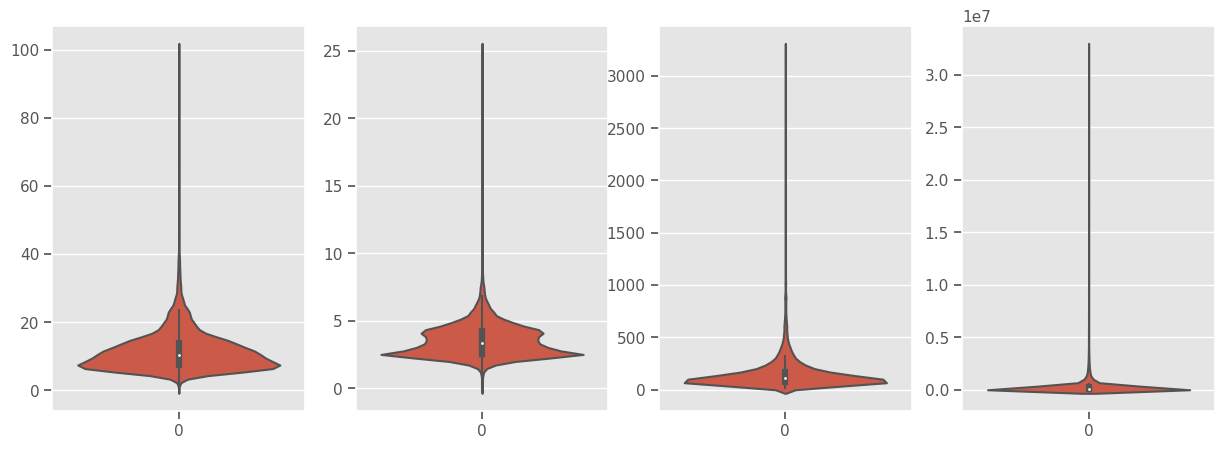

In [61]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.violinplot(df_clean['Length'], inner = 'box', ax = axes[0])
sns.violinplot(df_clean['Width'], inner = 'box', ax = axes[1])
sns.violinplot(df_clean['Number of views last 7 days'], inner = 'box', ax = axes[2])
sns.violinplot(df_clean['Price (USD)'], inner = 'box', ax = axes[3])

<AxesSubplot:xlabel='Price (USD)', ylabel='Count'>

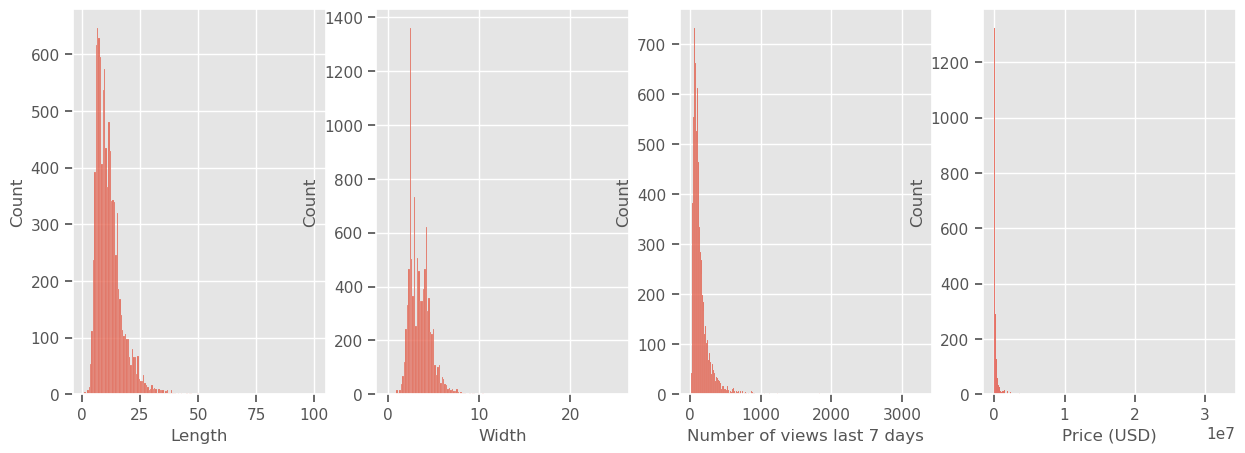

In [62]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.histplot(df_clean['Length'], ax = axes[0])
sns.histplot(df_clean['Width'], ax = axes[1])
sns.histplot(df_clean['Number of views last 7 days'], ax = axes[2])
sns.histplot(df_clean['Price (USD)'], ax = axes[3])

<AxesSubplot:xlabel='Price (USD)', ylabel='Count'>

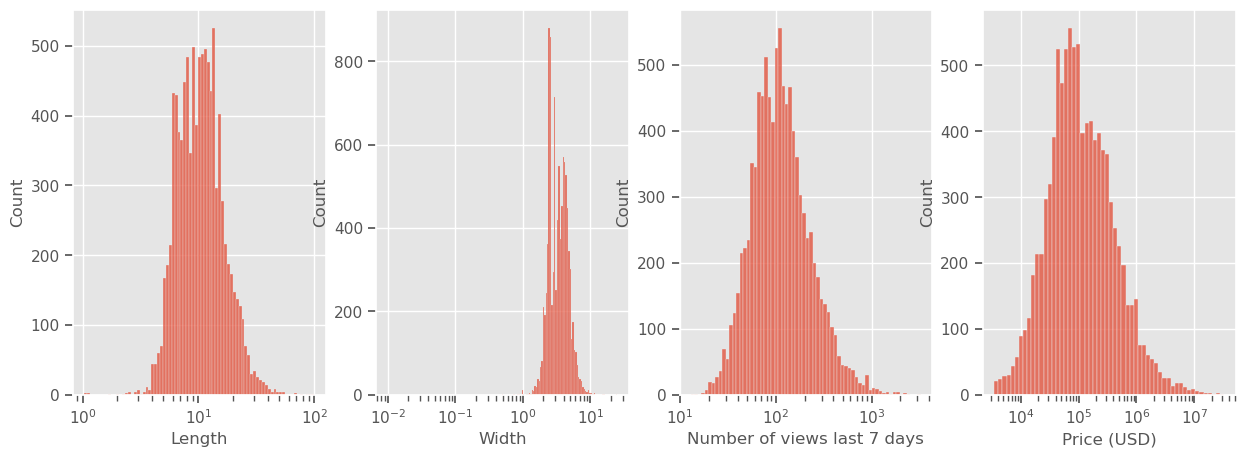

In [63]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.histplot(df_clean['Length'], ax = axes[0], log_scale = True)
sns.histplot(df_clean['Width'], ax = axes[1], log_scale = True)
sns.histplot(df_clean['Number of views last 7 days'], ax = axes[2], log_scale = True)
sns.histplot(df_clean['Price (USD)'], ax = axes[3], log_scale = True)

## Data Imputation

In [64]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 8550 non-null   object 
 2   Year Built                   9337 non-null   float64
 3   Length                       9879 non-null   float64
 4   Width                        9832 non-null   float64
 5   Material                     8139 non-null   object 
 6   Number of views last 7 days  9888 non-null   int64  
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9802 non-null   object 
 13  Fuel              

<AxesSubplot:>

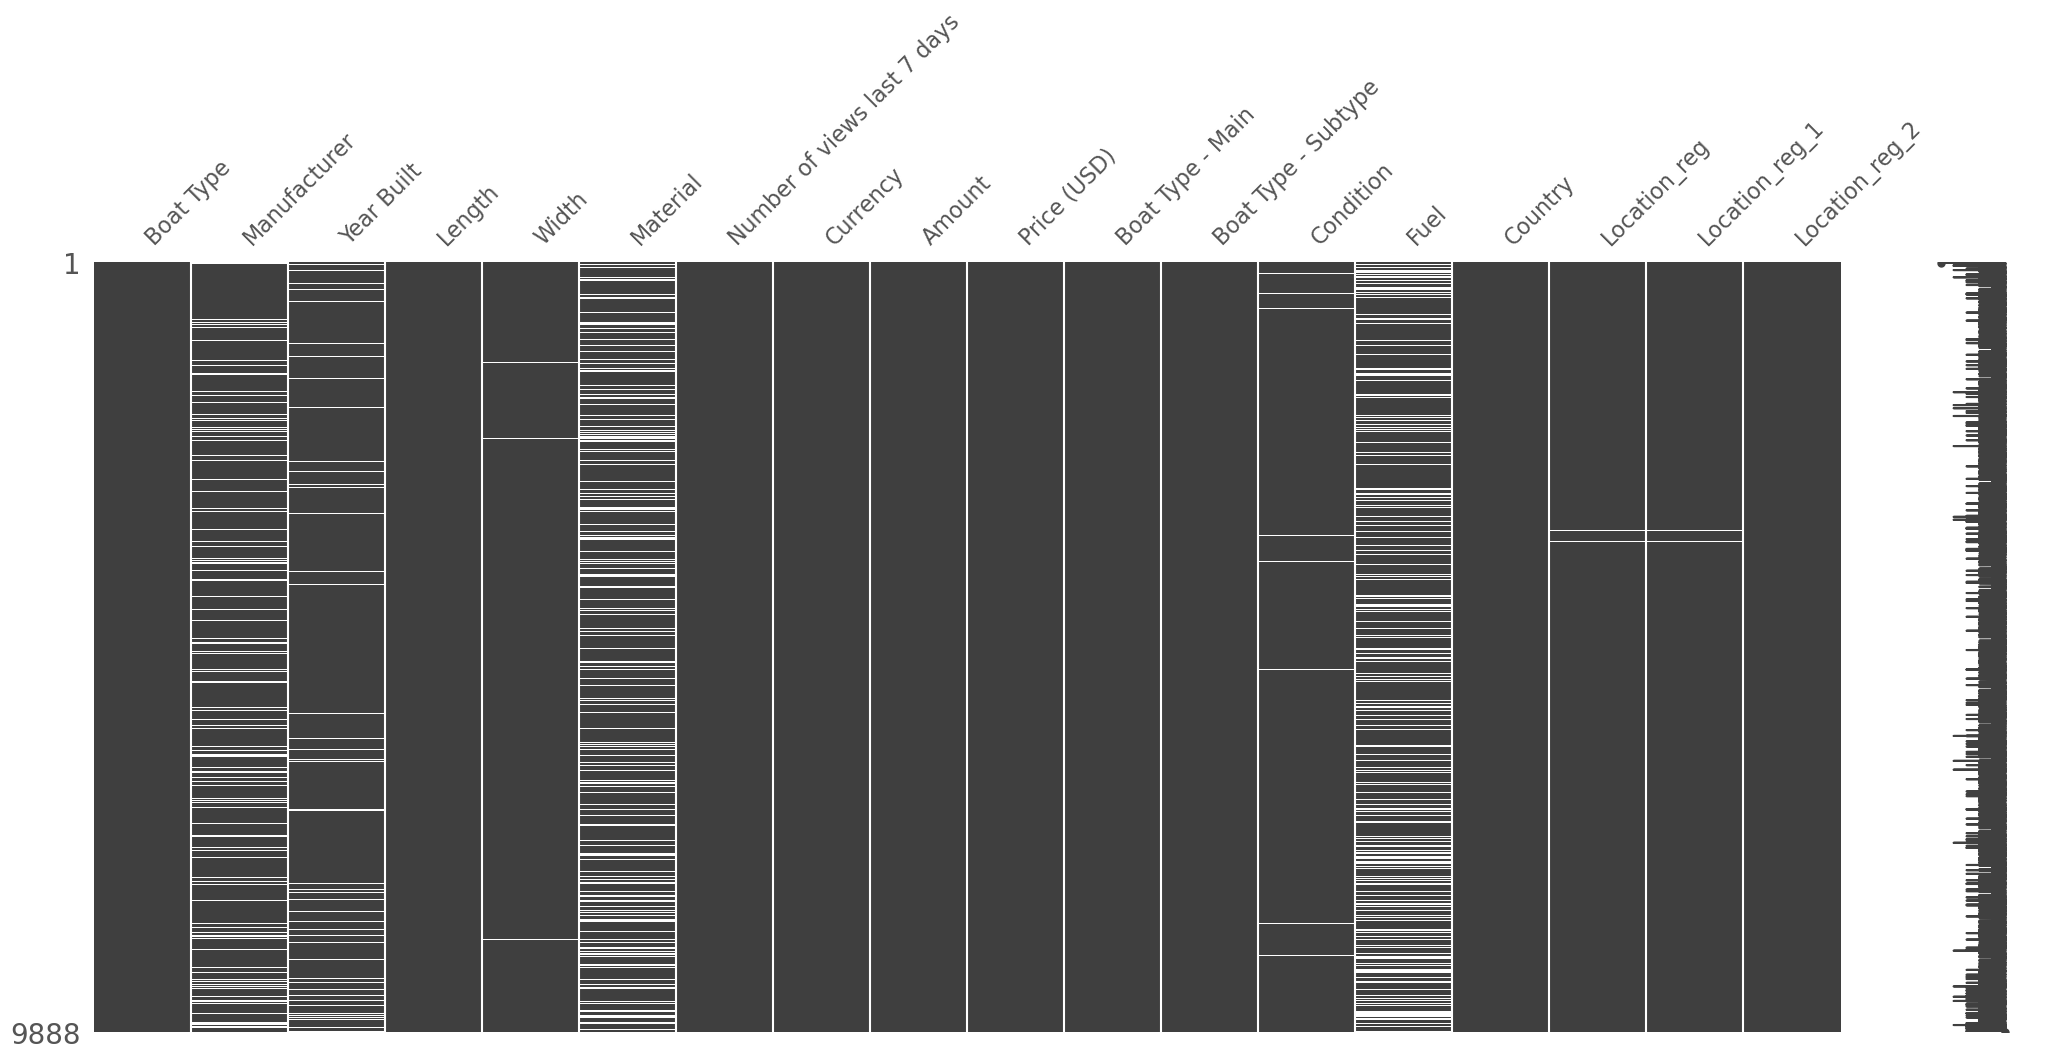

In [65]:
msno.matrix(df_clean)

<AxesSubplot:>

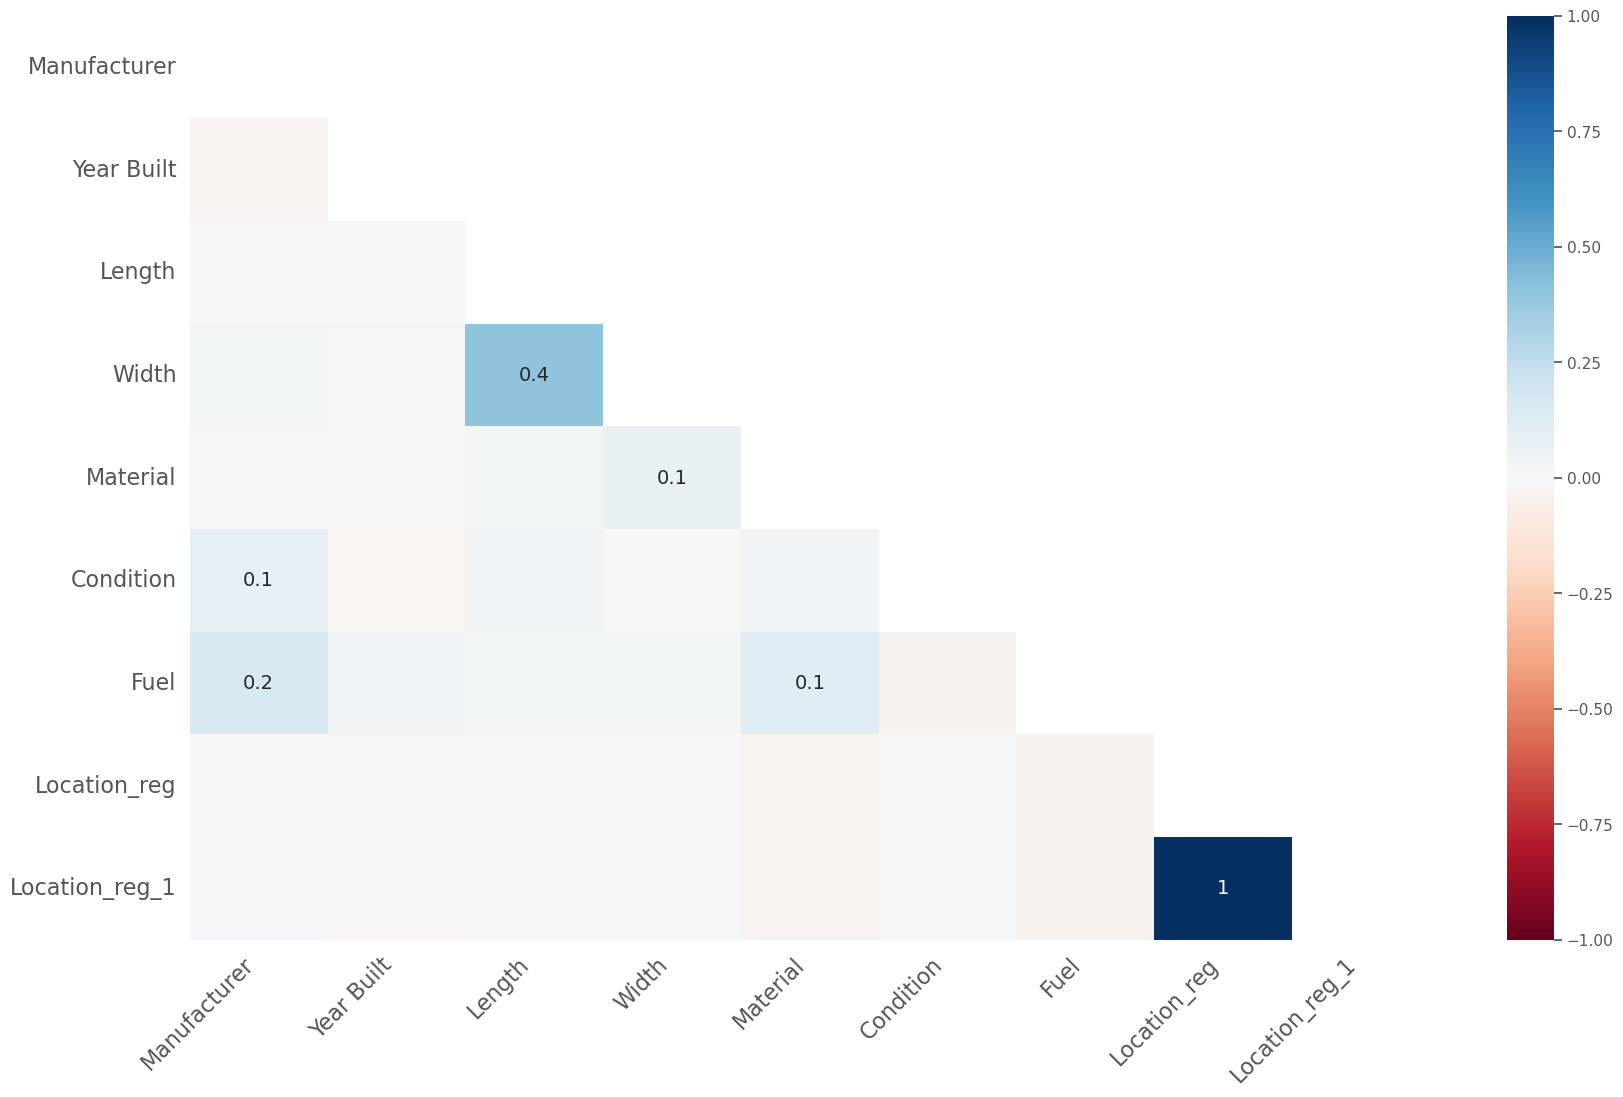

In [66]:
msno.heatmap(df_clean)

<AxesSubplot:>

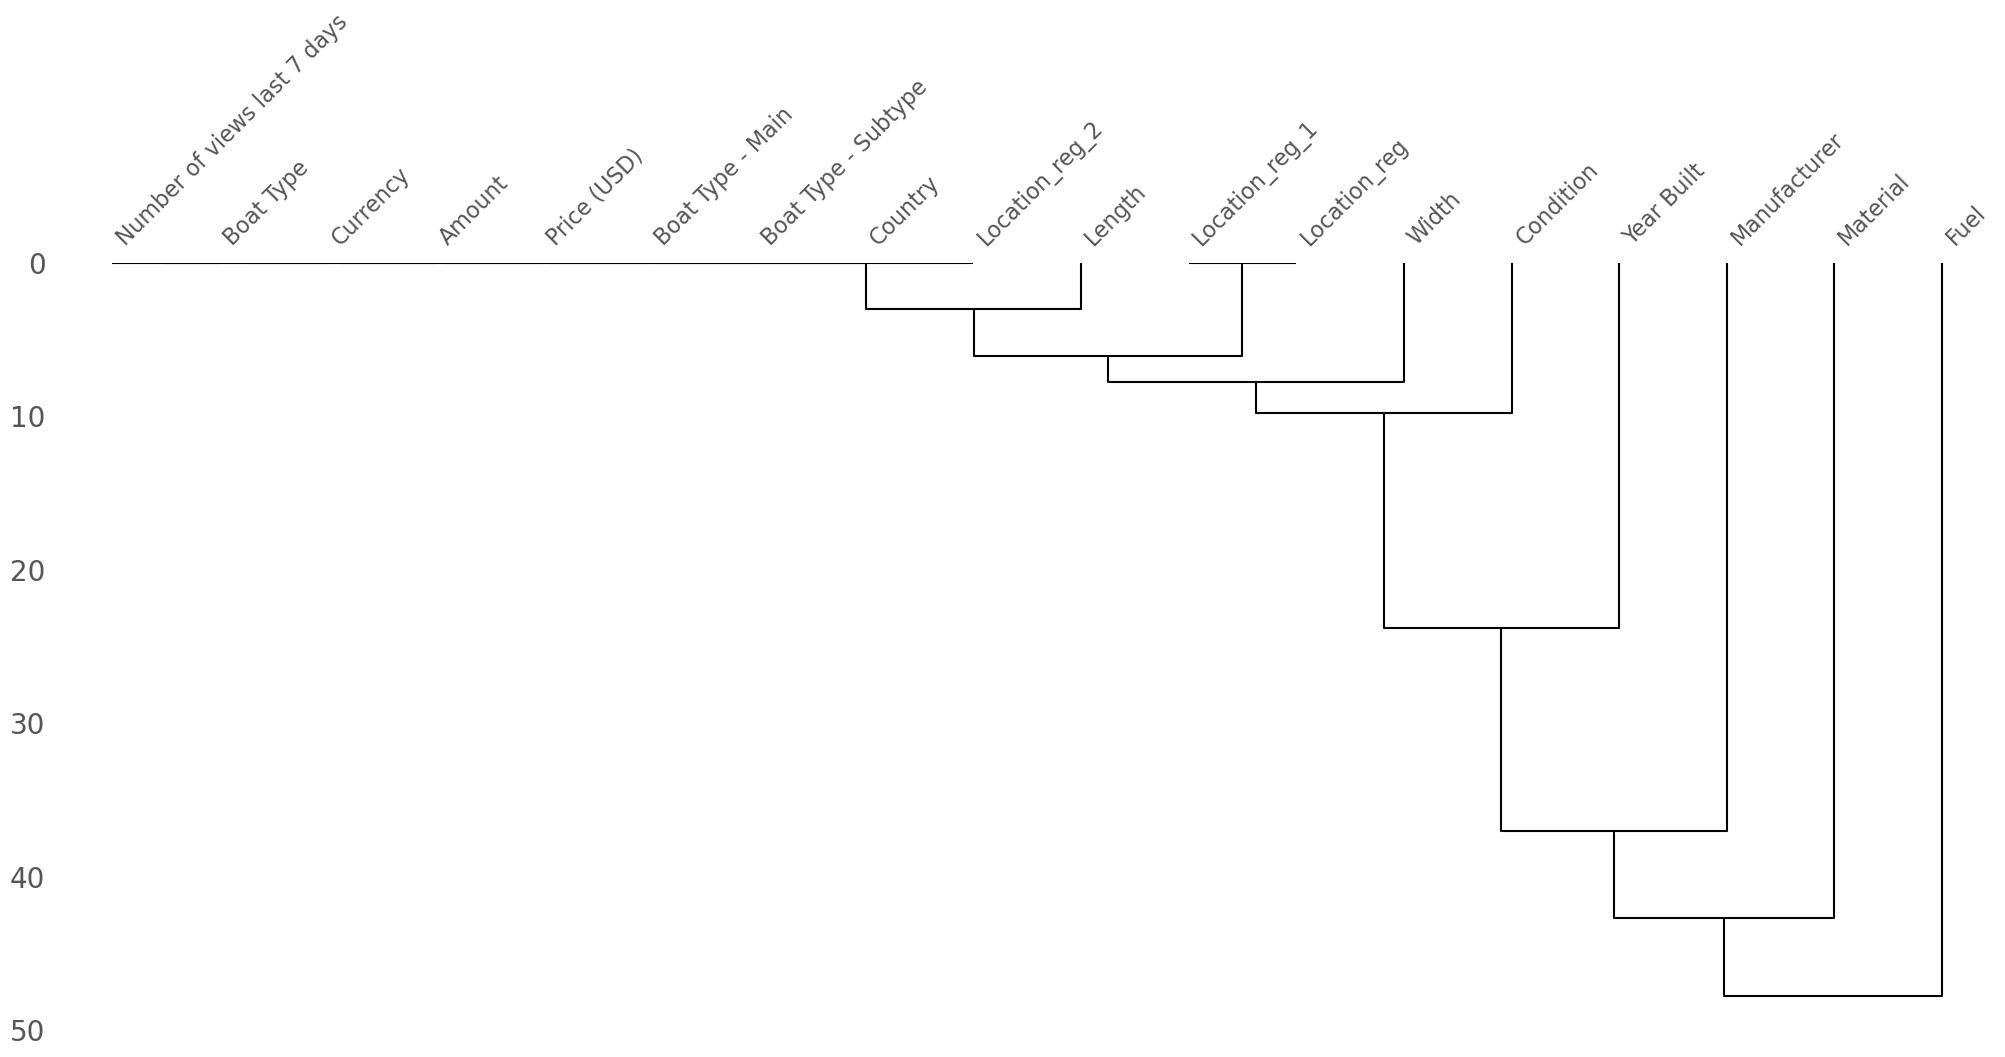

In [67]:
msno.dendrogram(df_clean)

In [68]:
cat_encode = OrdinalEncoder()
cat_cols = ['Boat Type', 'Manufacturer', 'Material', 'Currency', 'Condition', 'Fuel', 'Country' , 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'  ]
df_enc = df_clean.copy()
df_enc[cat_cols] = pd.DataFrame(cat_encode.fit_transform(df_clean[cat_cols]), columns = df_clean[cat_cols].columns)
df_enc.head()

Boat Type  Manufacturer  Year Built  Length  Width  Material  \
0       96.0         335.0      2017.0    4.00   1.90       NaN   
1       38.0         459.0      2020.0    4.00   1.50       9.0   
2      116.0         285.0         NaN    3.69   1.42       0.0   
3      116.0         352.0      2020.0    3.00   1.00       NaN   
4       73.0         263.0      2019.0    3.55   1.46       0.0   

   Number of views last 7 days  Currency   Amount  Price (USD)  \
0                          226       0.0   3337.0      3561.97   
1                           75       2.0   3490.0      3680.20   
2                          124       0.0   3770.0      4024.16   
3                           64       1.0  25900.0      3672.39   
4                           58       2.0   3399.0      3584.25   

   Boat Type - Main  Boat Type - Subtype  Condition  Fuel  Country  \
0              13.0                  0.0        2.0   NaN    102.0   
1               3.0                  0.0        2.0   NaN     39.0   
2              21.0                  0.0        2.0   NaN    102.0   
3              21.0                  0.0        2.0   NaN     27.0   
4               6.0                  0.0        2.0   NaN     39.0   

   Location_reg  Location_reg_1  Location_reg_2  
0        1303.0           780.0           886.0  
1         598.0           317.0             0.0  
2        1347.0           782.0           817.0  
3        2313.0          1455.0             0.0  
4         407.0           212.0           566.0

In [69]:
cat_encode.categories_

[array(['Bowrider', 'Bowrider,Cabin Boat,Deck Boat',
        'Bowrider,Center console boat,Sport Boat', 'Bowrider,Classic',
        'Bowrider,Deck Boat,Water ski', 'Bowrider,Motor Yacht,Sport Boat',
        'Bowrider,Motor Yacht,Wakeboard/Wakesurf',
        'Bowrider,Sport Boat,Wakeboard/Wakesurf',
        'Bowrider,Wakeboard/Wakesurf', 'Cabin Boat', 'Cabin Boat,Classic',
        'Cabin Boat,Classic,Flybridge', 'Cabin Boat,Classic,Motor Yacht',
        'Cabin Boat,Classic,Passenger boat', 'Cabin Boat,Classic,Trawler',
        'Cabin Boat,Fishing Boat', 'Cabin Boat,Fishing Boat,House Boat',
        'Cabin Boat,Fishing Boat,Pilothouse',
        'Cabin Boat,Fishing Boat,Sport Boat', 'Cabin Boat,Flybridge',
        'Cabin Boat,Flybridge,Motor Yacht', 'Cabin Boat,Hardtop',
        'Cabin Boat,Hardtop,Motor Yacht', 'Cabin Boat,Hardtop,Sport Boat',
        'Cabin Boat,Hardtop,Trawler', 'Cabin Boat,House Boat',
        'Cabin Boat,House Boat,Trawler', 'Cabin Boat,Motor Yacht',
        'Cabin B

In [70]:
imp = IterativeImputer(estimator = RandomForestRegressor(), missing_values= np.nan, max_iter=30, random_state=0)
imp.fit(df_enc)

IterativeImputer(estimator=RandomForestRegressor(), max_iter=30, random_state=0)

In [71]:
df_imp = pd.DataFrame(imp.transform(df_enc), columns = df_enc.columns )

In [72]:
df_imp.describe()

Boat Type  Manufacturer   Year Built       Length        Width  \
count  9888.000000   9888.000000  9888.000000  9888.000000  9888.000000   
mean     86.348706    253.358833  2005.482321    11.568452     3.519490   
std      32.334545    135.628583    16.294873     6.000513     1.220353   
min       0.000000      0.000000  1885.000000     1.040000     0.010000   
25%      80.000000    125.000000  2000.000000     7.470000     2.540000   
50%      96.000000    252.920000  2008.000000    10.280000     3.326600   
75%     109.000000    369.000000  2018.000000    13.920000     4.250000   
max     125.000000    513.000000  2021.000000   100.000000    25.160000   

          Material  Number of views last 7 days     Currency        Amount  \
count  9888.000000                  9888.000000  9888.000000  9.888000e+03   
mean      3.104949                   149.160801     1.813714  3.201373e+05   
std       2.180249                   151.819752     0.640406  1.007482e+06   
min       0.000000                    13.000000     0.000000  3.300000e+03   
25%       2.000000                    70.000000     2.000000  4.400000e+04   
50%       2.000000                   108.000000     2.000000  9.500000e+04   
75%       4.000000                   172.000000     2.000000  2.550000e+05   
max      10.000000                  3263.000000     3.000000  3.100000e+07   

        Price (USD)  Boat Type - Main  Boat Type - Subtype    Condition  \
count  9.888000e+03       9888.000000          9888.000000  9888.000000   
mean   3.187905e+05         12.037520             0.384001     1.254164   
std    1.021459e+06          6.793409             2.346425     0.518308   
min    3.479850e+03          0.000000             0.000000     0.000000   
25%    4.534350e+04          7.000000             0.000000     1.000000   
50%    9.761717e+04         13.000000             0.000000     1.000000   
75%    2.622615e+05         17.000000             0.000000     1.000000   
max    3.268950e+07         25.000000            21.000000     3.000000   

              Fuel      Country  Location_reg  Location_reg_1  Location_reg_2  
count  9888.000000  9888.000000   9888.000000     9888.000000     9888.000000  
mean      1.630900    55.927892   1176.085001      710.148174      185.761731  
std       1.889185    28.208488    824.233833      521.608332      288.639505  
min       0.000000     0.000000      0.000000        0.000000        0.000000  
25%       0.000000    34.000000    441.750000      230.750000        0.000000  
50%       0.000000    47.000000   1126.000000      750.000000        0.000000  
75%       4.000000    71.000000   1797.250000     1026.000000      347.250000  
max       4.000000   125.000000   2714.000000     1767.000000     1008.000000

In [73]:
df_enc.describe()

Boat Type  Manufacturer   Year Built       Length        Width  \
count  9888.000000   8550.000000  9337.000000  9879.000000  9832.000000   
mean     86.348706    251.207836  2004.914962    11.570017     3.520124   
std      32.334545    143.940737    16.356241     6.002820     1.220534   
min       0.000000      0.000000  1885.000000     1.040000     0.010000   
25%      80.000000    108.000000  1999.000000     7.470000     2.540000   
50%      96.000000    245.000000  2008.000000    10.280000     3.330000   
75%     109.000000    371.000000  2018.000000    13.930000     4.250000   
max     125.000000    513.000000  2021.000000   100.000000    25.160000   

          Material  Number of views last 7 days     Currency        Amount  \
count  8139.000000                  9888.000000  9888.000000  9.888000e+03   
mean      3.182209                   149.160801     1.813714  3.201373e+05   
std       2.335278                   151.819752     0.640406  1.007482e+06   
min       0.000000                    13.000000     0.000000  3.300000e+03   
25%       2.000000                    70.000000     2.000000  4.400000e+04   
50%       2.000000                   108.000000     2.000000  9.500000e+04   
75%       4.000000                   172.000000     2.000000  2.550000e+05   
max      10.000000                  3263.000000     3.000000  3.100000e+07   

        Price (USD)  Boat Type - Main  Boat Type - Subtype    Condition  \
count  9.888000e+03       9888.000000          9888.000000  9802.000000   
mean   3.187905e+05         12.037520             0.384001     1.255968   
std    1.021459e+06          6.793409             2.346425     0.519861   
min    3.479850e+03          0.000000             0.000000     0.000000   
25%    4.534350e+04          7.000000             0.000000     1.000000   
50%    9.761717e+04         13.000000             0.000000     1.000000   
75%    2.622615e+05         17.000000             0.000000     1.000000   
max    3.268950e+07         25.000000            21.000000     3.000000   

              Fuel      Country  Location_reg  Location_reg_1  Location_reg_2  
count  7676.000000  9888.000000   9852.000000     9852.000000     9888.000000  
mean      1.595362    55.927892   1176.411592      710.145351      185.761731  
std       1.951503    28.208488    825.720779      522.560557      288.639505  
min       0.000000     0.000000      0.000000        0.000000        0.000000  
25%       0.000000    34.000000    433.750000      222.750000        0.000000  
50%       0.000000    47.000000   1129.000000      753.000000        0.000000  
75%       4.000000    71.000000   1803.250000     1030.250000      347.250000  
max       4.000000   125.000000   2714.000000     1767.000000     1008.000000

In [74]:
df_clean_impd = df_imp.copy()
df_clean_impd[cat_cols] = pd.DataFrame(cat_encode.inverse_transform(df_clean_impd[cat_cols]), columns = cat_cols)
df_clean_impd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 9888 non-null   object 
 2   Year Built                   9888 non-null   float64
 3   Length                       9888 non-null   float64
 4   Width                        9888 non-null   float64
 5   Material                     9888 non-null   object 
 6   Number of views last 7 days  9888 non-null   float64
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9888 non-null   object 
 13  Fuel              

In [75]:
[df_clean_impd['Country'].nunique(), df_clean['Country'].nunique()]

[126, 126]

In [76]:
# Winsorize Outliers 
outlier_columns = ['Length', 'Width', 'Number of views last 7 days', 'Price (USD)']
limits = [[0.002, 0.001], [0.004, 0.005], [0.0001, 0.001], [0.00001, 0.001]]
df_clean_impd_wind = df_clean_impd.copy()

for i in range(4):
    current_col = outlier_columns[i]
    current_lim = limits[i] 
    df_clean_impd_wind[current_col] = pd.DataFrame(stats.mstats.winsorize(df_clean_impd_wind[current_col], limits = current_lim))

df_clean_impd_wind.describe()

Year Built       Length        Width  Number of views last 7 days  \
count  9888.000000  9888.000000  9888.000000                  9888.000000   
mean   2005.482321    11.551826     3.511943                   148.811691   
std      16.294873     5.819825     1.162542                   146.954498   
min    1885.000000     3.000000     1.420000                    13.000000   
25%    2000.000000     7.470000     2.540000                    70.000000   
50%    2008.000000    10.280000     3.326600                   108.000000   
75%    2018.000000    13.920000     4.250000                   172.000000   
max    2021.000000    53.500000     8.000000                  1804.000000   

             Amount   Price (USD)  
count  9.888000e+03  9.888000e+03  
mean   3.201373e+05  3.138662e+05  
std    1.007482e+06  9.168856e+05  
min    3.300000e+03  3.479850e+03  
25%    4.400000e+04  4.534350e+04  
50%    9.500000e+04  9.761717e+04  
75%    2.550000e+05  2.622615e+05  
max    3.100000e+07  1.565932e+07

In [77]:
df_clean_impd_wind.drop(['Amount', 'Currency'], axis = 1, inplace = True)
df_clean_impd_wind.rename(columns = {'Number of views last 7 days' : 'Views (last 7 days)', 'Year Built': 'Year'}, inplace=True)

<AxesSubplot:xlabel='Price (USD)', ylabel='Count'>

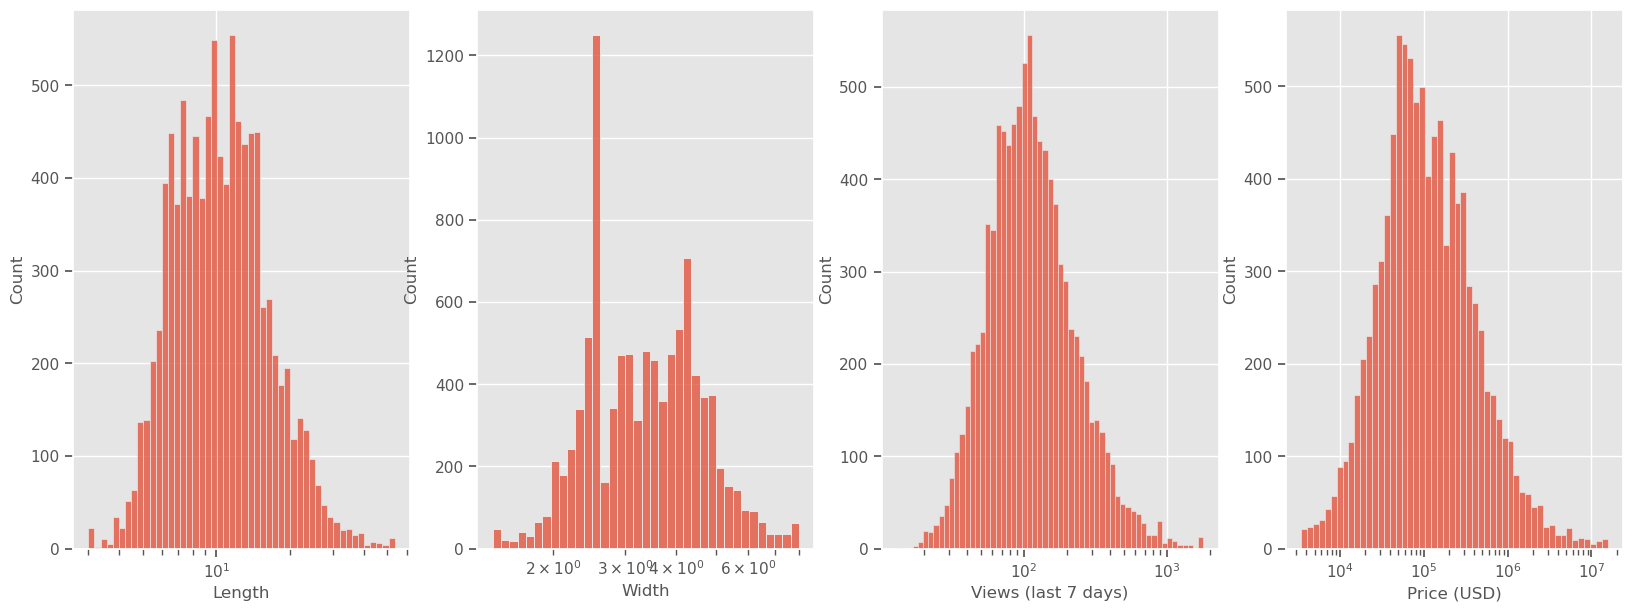

In [78]:
fig, axes = plt.subplots(1,4,figsize=(20,7))
sns.histplot(df_clean_impd_wind['Length'], ax = axes[0], log_scale = True)
sns.histplot(df_clean_impd_wind['Width'], ax = axes[1], log_scale = True)
sns.histplot(df_clean_impd_wind['Views (last 7 days)'], ax = axes[2], log_scale = True)
sns.histplot(df_clean_impd_wind['Price (USD)'], ax = axes[3], log_scale = True)

<AxesSubplot:>

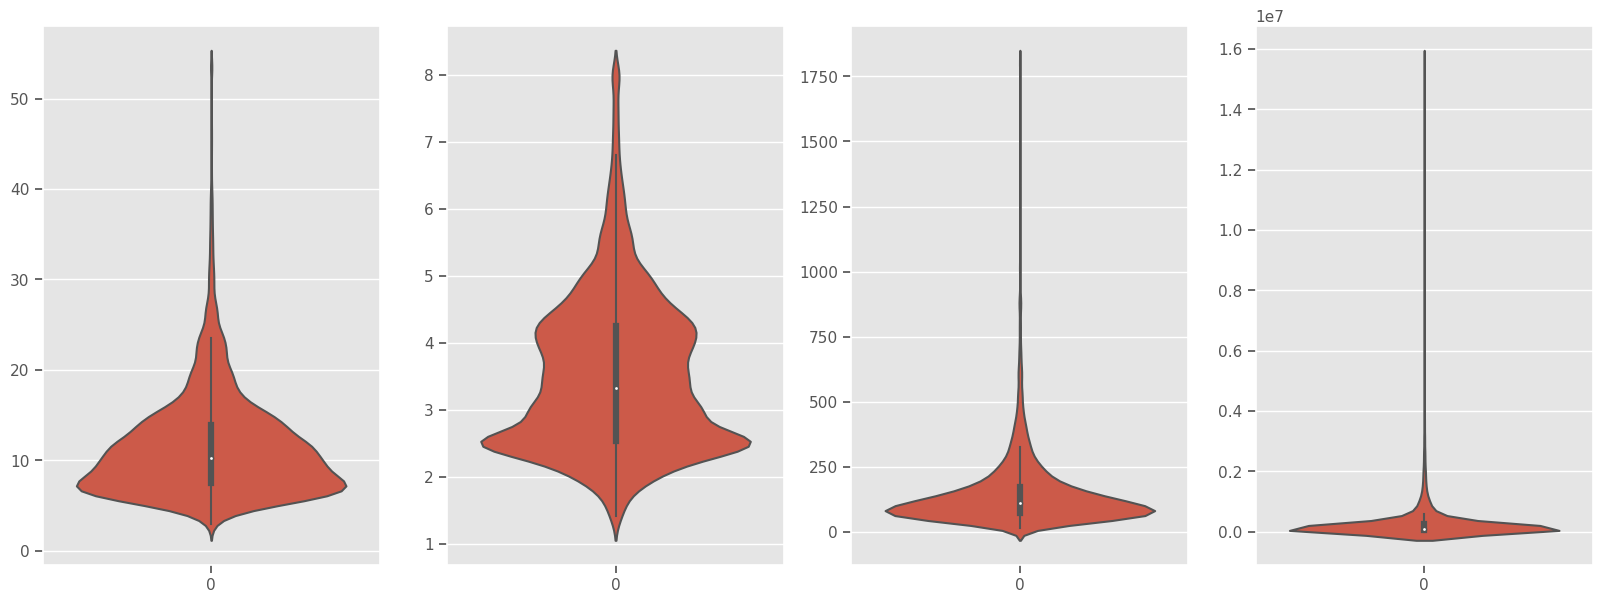

In [79]:
fig, axes = plt.subplots(1,4,figsize=(20,7))
sns.violinplot(df_clean_impd_wind['Length'], inner = 'box', ax = axes[0])
sns.violinplot(df_clean_impd_wind['Width'], inner = 'box', ax = axes[1])
sns.violinplot(df_clean_impd_wind['Views (last 7 days)'], inner = 'box', ax = axes[2])
sns.violinplot(df_clean_impd_wind['Price (USD)'], inner = 'box', ax = axes[3])

In [80]:
df_clean_impd_wind['Log(Views_7d)'] = np.log10(df_clean_impd_wind['Views (last 7 days)'])
df_clean_impd_wind['Log(Length)'] = np.log10(df_clean_impd_wind['Length'])
df_clean_impd_wind['Log(Width)'] = np.log10(df_clean_impd_wind['Width'])
df_clean_impd_wind['Log(Price)'] = np.log10(df_clean_impd_wind['Price (USD)'])

Note - Perfrom Box Cogg transformation to reduce these distributions to a normal one

# <a id='toc5_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc5_1_1_'></a>[Target Variable - Views (7 days)](#toc0_)

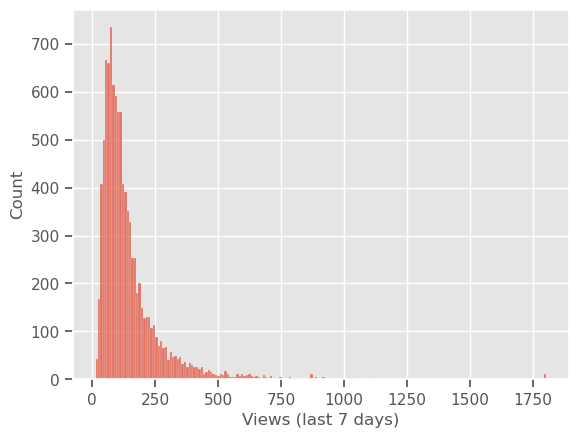

In [81]:
sns.histplot(df_clean_impd_wind['Views (last 7 days)'])
plt.show()

[Text(0.5, 1.0, 'The Correlation Heatmap between Numeric Variables')]

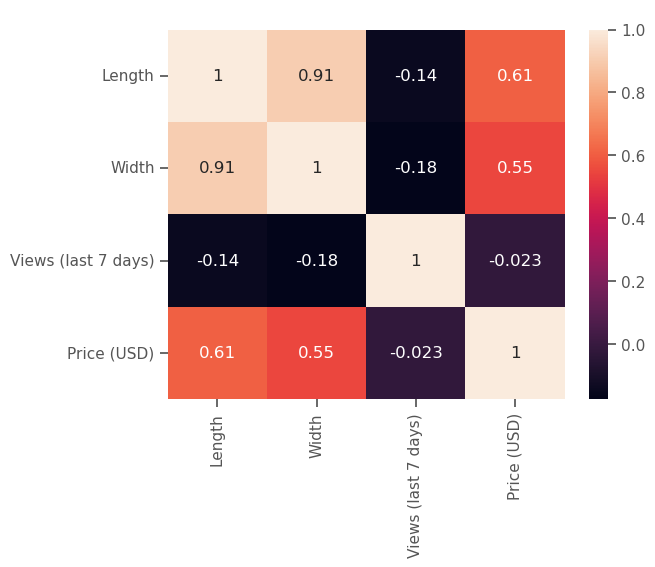

In [82]:
num_columns = ['Length', 'Width', 'Views (last 7 days)', 'Price (USD)']
num_cols = df_clean_impd_wind[num_columns]
sns.heatmap(num_cols.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables')

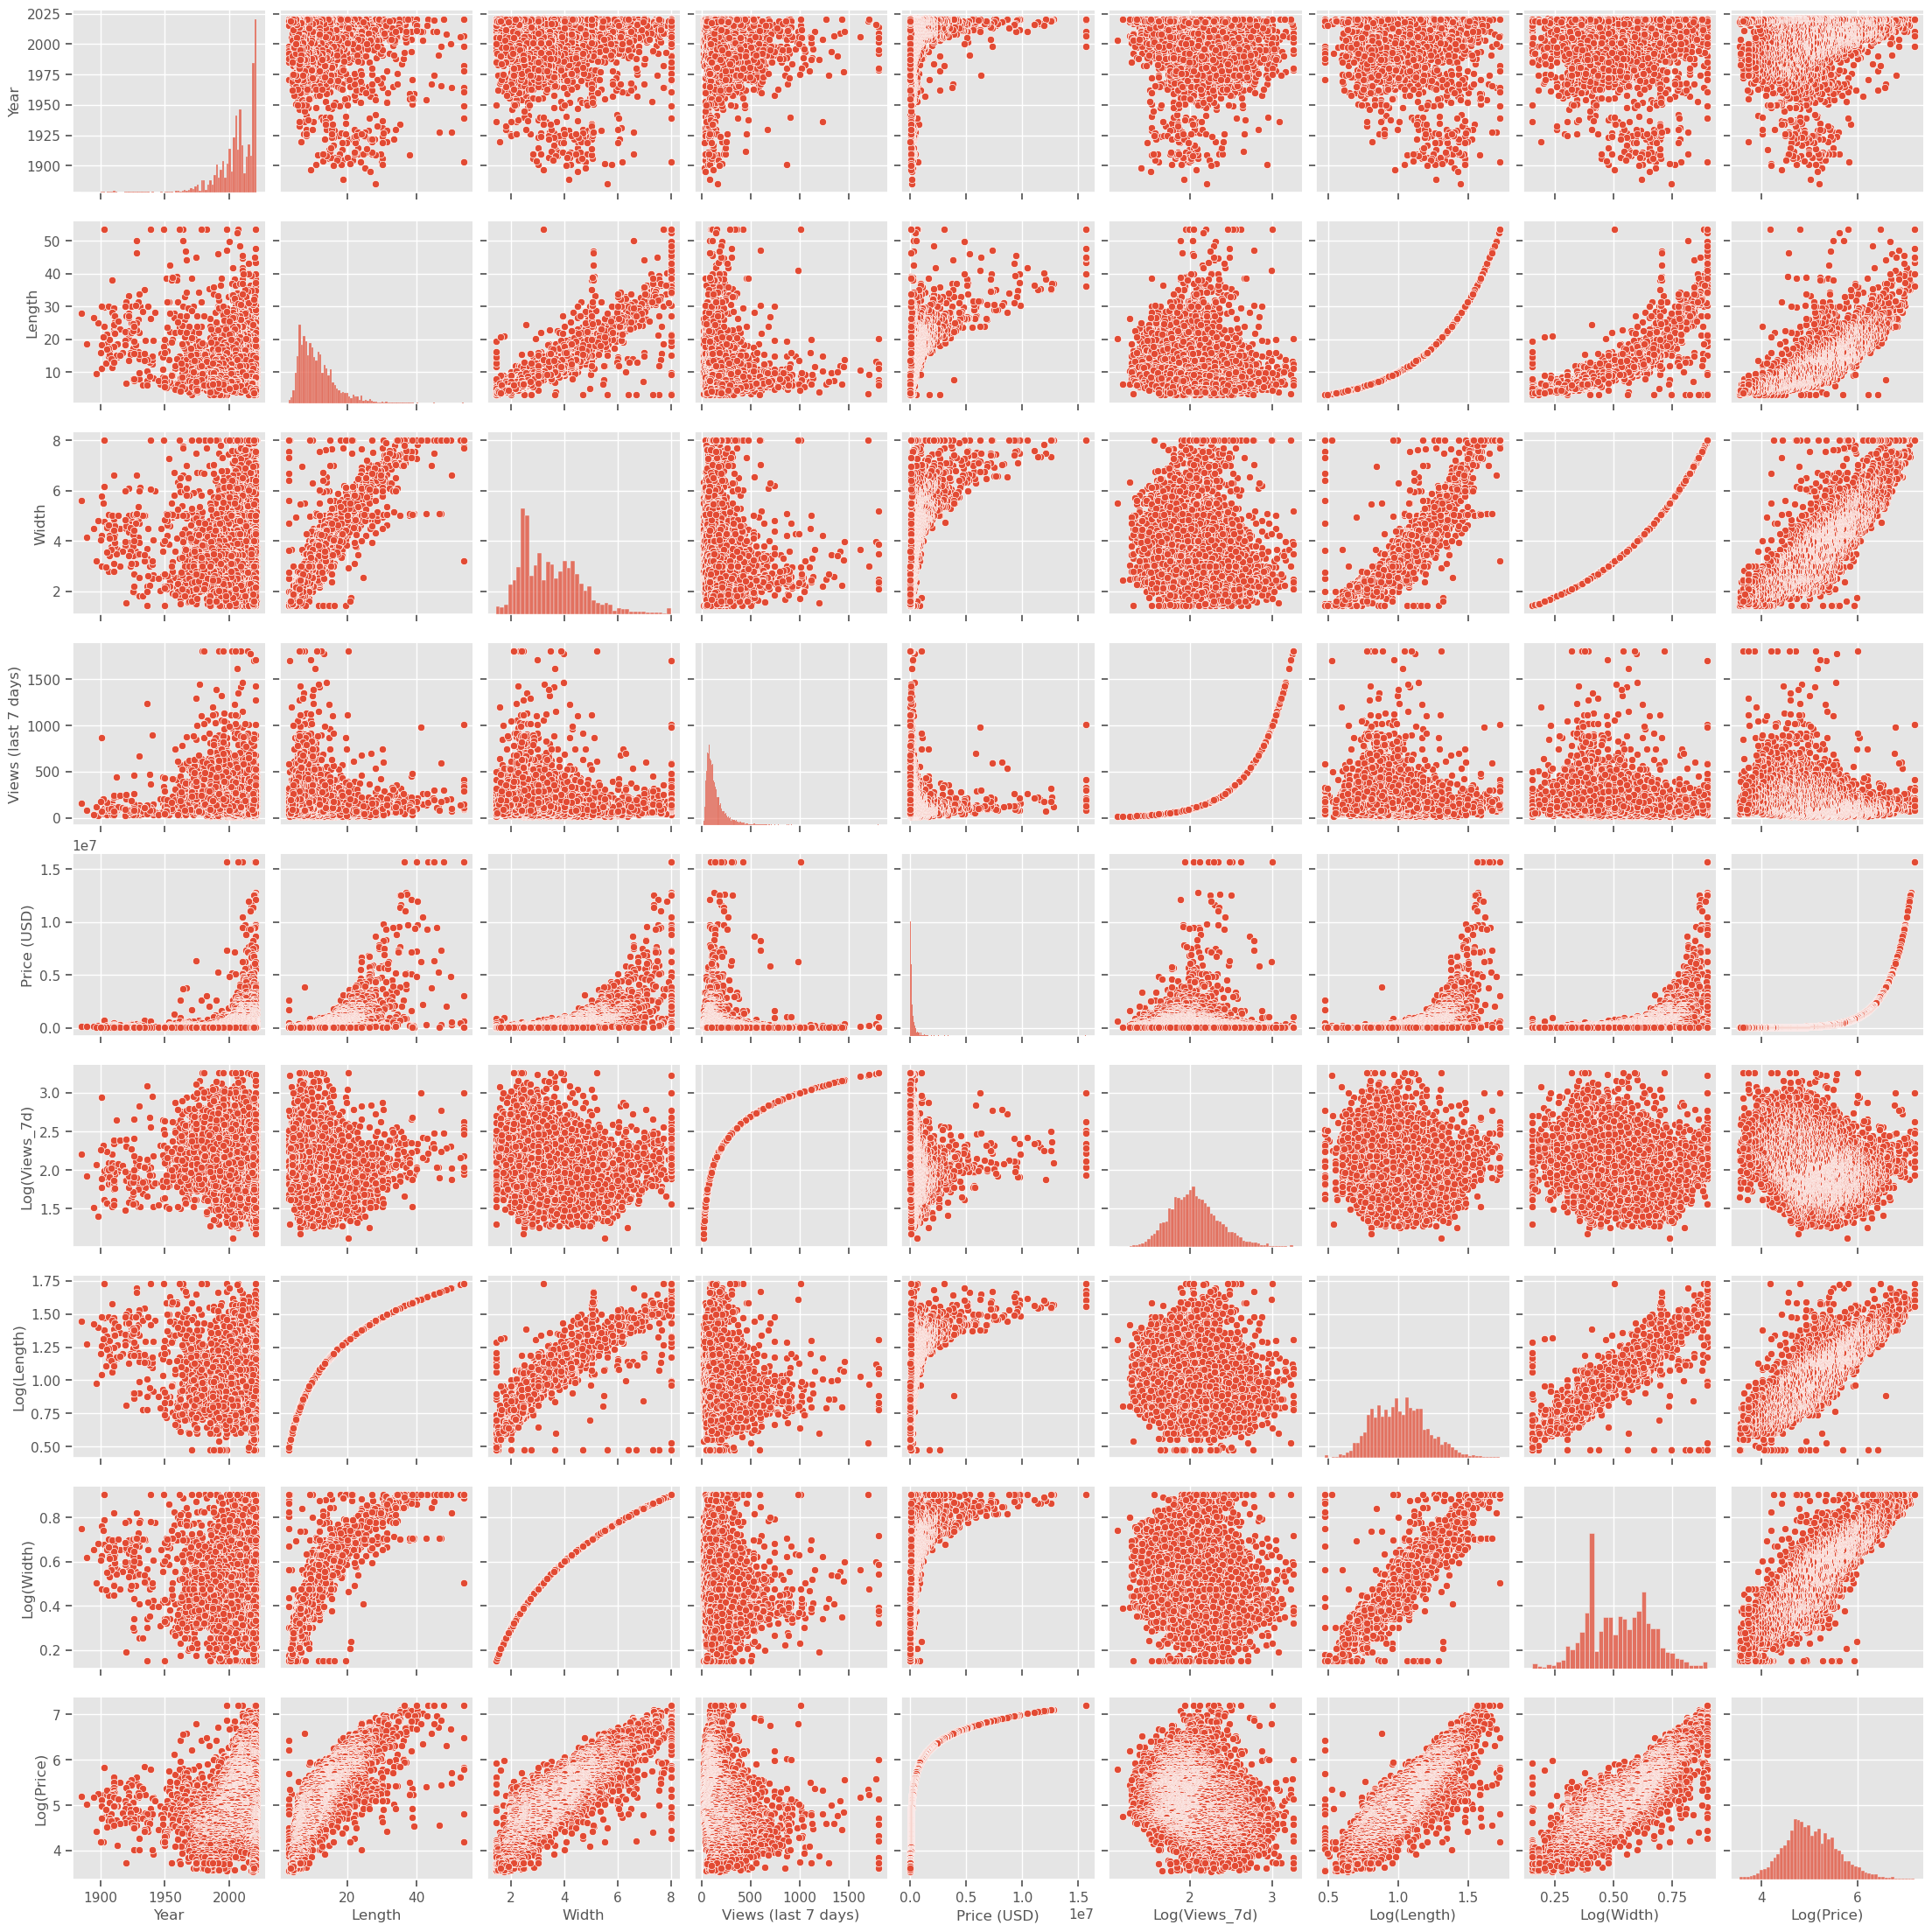

In [83]:
sns.pairplot(df_clean_impd_wind)
plt.show()

<AxesSubplot:xlabel='Price (USD)', ylabel='Log(Views_7d)'>

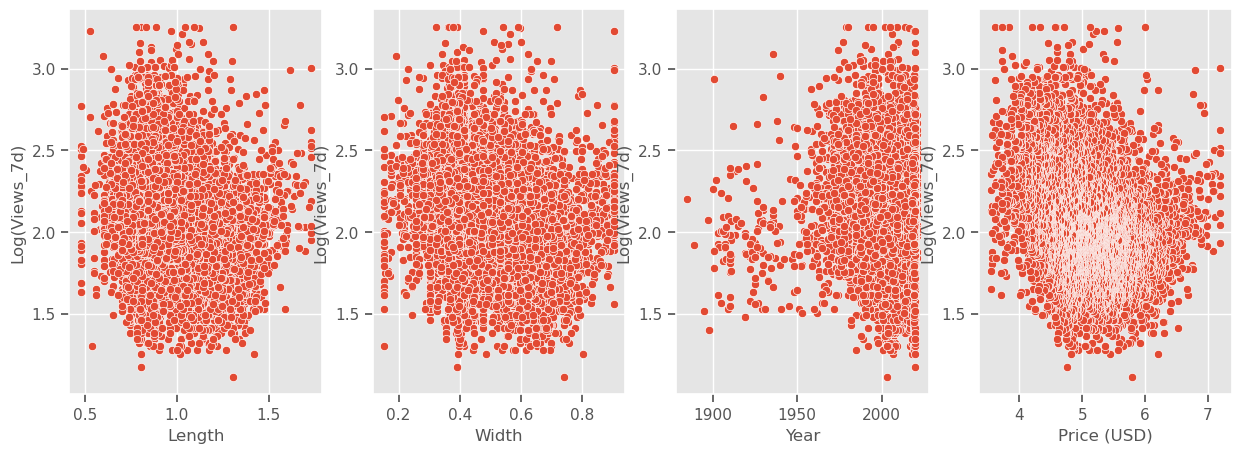

In [84]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Length']), ax=axes[0])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Width']), ax=axes[1])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = df_clean_impd_wind['Year'], ax=axes[2])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Price (USD)']), ax=axes[3])

This might be a problem for the model as there seems to be no notable dependency on the numeric variables

<AxesSubplot:xlabel='Year', ylabel='Log(Price)'>

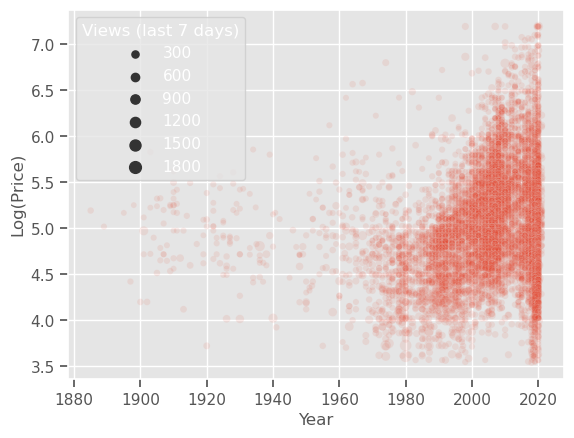

In [85]:
sns.scatterplot( data = df_clean_impd_wind, x = 'Year', y = 'Log(Price)', size = 'Views (last 7 days)', alpha = 0.1)

# <a id='toc6_'></a>[Model Fitting and Evaluation](#toc0_)

### <a id='toc6_1_1_'></a>[Prepare Data for Modeling](#toc0_)
- Normalize features
- Convert categorical values into numeric features
- Split data into training and test set


In [86]:
df_clean_impd_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Boat Type            9888 non-null   object 
 1   Manufacturer         9888 non-null   object 
 2   Year                 9888 non-null   float64
 3   Length               9888 non-null   float64
 4   Width                9888 non-null   float64
 5   Material             9888 non-null   object 
 6   Views (last 7 days)  9888 non-null   float64
 7   Price (USD)          9888 non-null   float64
 8   Boat Type - Main     9888 non-null   object 
 9   Boat Type - Subtype  9888 non-null   object 
 10  Condition            9888 non-null   object 
 11  Fuel                 9888 non-null   object 
 12  Country              9888 non-null   object 
 13  Location_reg         9888 non-null   object 
 14  Location_reg_1       9888 non-null   object 
 15  Location_reg_2       9888 non-null   o

In [87]:
df_model = df_clean_impd_wind.copy()
cat_encode = OrdinalEncoder()
cat_cols = ['Boat Type', 'Manufacturer', 'Material', 'Condition', 'Fuel', 'Country', 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'   ]


df_model[cat_cols] = cat_encode.fit_transform(df_model[cat_cols]) 

In [88]:
df_model.columns

Index(['Boat Type', 'Manufacturer', 'Year', 'Length', 'Width', 'Material',
       'Views (last 7 days)', 'Price (USD)', 'Boat Type - Main',
       'Boat Type - Subtype', 'Condition', 'Fuel', 'Country', 'Location_reg',
       'Location_reg_1', 'Location_reg_2', 'Log(Views_7d)', 'Log(Length)',
       'Log(Width)', 'Log(Price)'],
      dtype='object')

In [89]:
feature_cols = ['Boat Type', 'Manufacturer', 'Year', 'Material', 'Condition', 'Fuel', 'Country', 'Log(Length)', 'Log(Width)', 'Log(Price)', 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'  ]
X = df_model[feature_cols]           # Features
y = df_model['Log(Views_7d)']  # Target variable

In [90]:
# define the scaler 
scaler = PowerTransformer()
# fit and transform the train set
#X[['Year','Length', 'Width', 'Price (USD)', 'Log(Length)', 'Log(Width)', 'Log(Price)']] = scaler.fit_transform(X[['Year','Length', 'Width', 'Price (USD)', 'Log(Length)', 'Log(Width)', 'Log(Price)']])
X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']] = scaler.fit_transform(X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']])

/home/amat/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/amat/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/tmp/ipykernel_63729/1425764335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']] = scaler.fit_transform(X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']])


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### <a id='toc6_1_2_'></a>[Linear Regression Model](#toc0_)

In [92]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [93]:
y_pred = lr.predict(X_test)
print('Linear Regression r2_score: ',r2_score(y_test,y_pred))
print('Linear Regression Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Linear Regression r2_score:  0.23135721822296862
Linear Regression Root Mean Squared Error:  0.2740945703853972


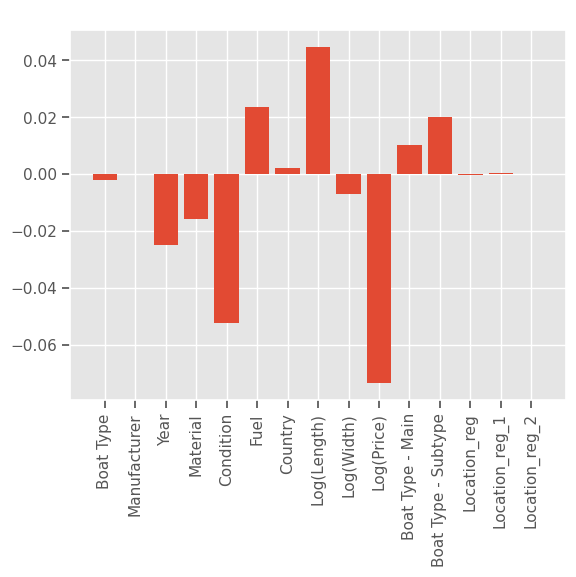

In [94]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model');

### <a id='toc6_1_3_'></a>[Decision Tree Regression Model](#toc0_)

In [95]:
tree = DecisionTreeRegressor(max_depth=12,min_samples_split=2,random_state=42)
tree.fit(X_train,y_train)
y_pred2 = tree.predict(X_test)

In [96]:
d_r2 = tree.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Decision Tree Regressor R-squared: 0.2861852410856559
Decision Tree Regressor RMSE: 0.26413801976004425


### <a id='toc6_1_4_'></a>[Random Forest Regresison Model](#toc0_)

In [97]:
forest = RandomForestRegressor() #max_depth=50,min_samples_split=2,random_state=42
forest.fit(X_train,y_train)
y_pred2 = forest.predict(X_test)

In [98]:
d_r2 = forest.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Decision Tree Regressor R-squared: 0.48827661438838965
Decision Tree Regressor RMSE: 0.22364324662524496


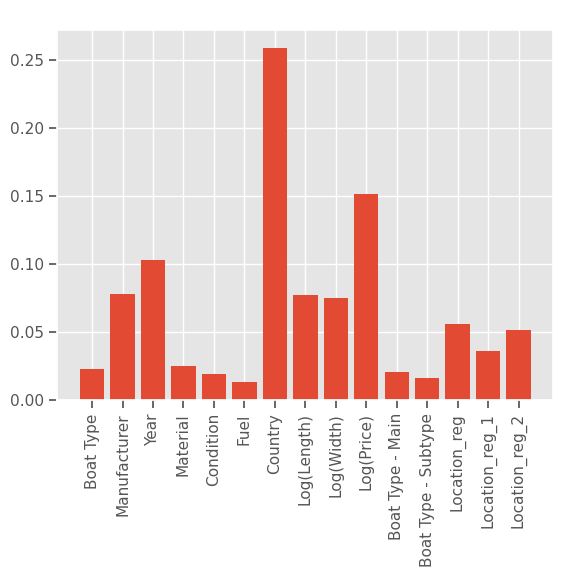

In [99]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = forest.feature_importances_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Regression Model');

### <a id='toc6_1_5_'></a>[Finding the best parameter for Decision Tree Regression Model](#toc0_)

Best max_depth is: 17 
Testing R^2 is: 0.49009031751398857


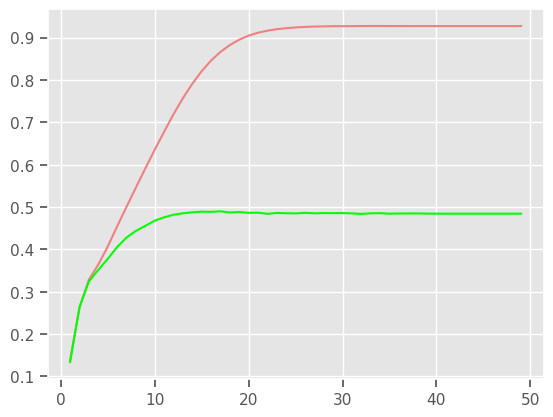

In [100]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    tree = RandomForestRegressor(max_depth=i,random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    train_score.append(tree.score(X_train,y_train))
    test_score.append(r2_score(y_test,y_pred))
    test_pair = (i,r2_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training R^2",color='lightcoral')
ax.plot(np.arange(1,50), test_score, label = "Testing R^2",color='lime')
print(f'Best max_depth is: {max_pair[0]} \nTesting R^2 is: {max_pair[1]}')

### <a id='toc6_1_6_'></a>[Gradient Boosting Regression Model](#toc0_)

In [101]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.predict(X_test[1:2])
reg.score(X_test, y_test)

0.4569971144124424

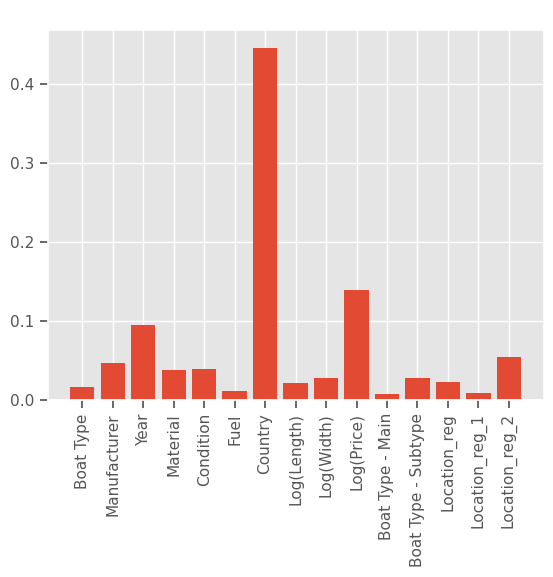

In [102]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = reg.feature_importances_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Regression Model');